No need to run these two cells (unless you want to run on Colab)

In [1]:
# !pip install pgmpy
# !pip install graphviz

In [2]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')

# # Define the path to your desired directory in Google Drive
# drive_path = '/content/drive/MyDrive/Colab Notebooks/FAIKRM3'

# # Change the current working directory
# os.chdir(drive_path)

# print(f"Current working directory changed to: {os.getcwd()}")

## Importing libraries + Helper functions + final Dataset

In [ ]:
# Check and install dependencies for the correct execution of the notebook
import sys
import subprocess
import importlib.util

# List of packages to check.
# The key is the package name for pip, the value is the name used in import
packages = {
    'pandas': 'pandas',
    'numpy': 'numpy',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
    'scipy': 'scipy',
    'scikit-learn': 'sklearn',
    'networkx': 'networkx',
    'graphviz': 'graphviz',
    'pgmpy': 'pgmpy'
}

print("Checking and installing dependencies...")

for package, import_name in packages.items():
    # Check if the package can be imported
    if importlib.util.find_spec(import_name) is None:
        print(f"{package} not found. Installing...")
        try:
            # Run pip install command
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"{package} installed successfully.")
        except subprocess.CalledProcessError:
            print(f"ERROR: Could not install {package}.")
    else:
        print(f"{package} is already present.")

print("Verification complete. The environment is ready!")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as ss

from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mutual_info_score

import networkx as nx
import graphviz
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.estimators import HillClimbSearch, PC, MmhcEstimator, TreeSearch
from pgmpy.estimators import BIC, BDeu, K2, AIC
from pgmpy.estimators import ExpertKnowledge
from pgmpy.base import DAG, PDAG
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD

from IPython.display import display
import matplotlib.ticker as mtick # For nice % formatting

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from graphviz import Digraph

### Helper functions

In [ ]:
# Helper functions

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    with np.errstate(divide='ignore', invalid='ignore'):
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        if min((kcorr-1), (rcorr-1)) == 0:
            result = 0
        else:
            result = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    return result

def visualize_structure(structure, title):
    if structure is None:
        print(f"Skipping visualization for {title} (No model found)")
        return

    edge_count = len(structure.edges())
    title_with_count = f"{title} (Edges: {edge_count})"
    print(f"Plotting: {title_with_count}")

    dot = graphviz.Digraph(comment=title)
    dot.attr(label=title_with_count, labelloc='t', fontsize='15', rankdir='TB')
    dot.attr('node', shape='ellipse', style='filled', color='lightblue2')

    for node in structure.nodes():
        dot.node(str(node), str(node))

    if isinstance(structure, PDAG):
        for edge in structure.edges():
            u, v = edge
            if structure.has_edge(v, u) and structure.has_edge(u, v):
                if u < v: dot.edge(str(u), str(v), dir='none', color='gray')
            else:
                dot.edge(str(u), str(v))
    else:
        for edge in structure.edges():
            dot.edge(str(edge[0]), str(edge[1]))
    display(dot)

def get_target_label(col):
    unique_vals = sorted(df[col].dropna().unique().astype(str))
    for val in unique_vals:
        if val.lower() in ['high', 'yes', 'true', '1', 'burnout']: return val
    return unique_vals[-1]

def get_extreme_state(col, direction='max'):
    try: return sorted(df[col].dropna().unique().astype(str))[-1 if direction=='max' else 0]
    except: return None

def get_prob(result, var, state):
    try: return result.values[result.state_names[var].index(state)]
    except: return 0.0

def causal_inference(target_var, intervention_var, intervention_val):
    model_int = model.copy()
    parents = model_int.get_parents(intervention_var)
    for parent in parents: model_int.remove_edge(parent, intervention_var)

    try:
        states = model.get_cpds(intervention_var).state_names[intervention_var]
        probs = np.zeros(len(states))
        # Flexible matching
        try: idx = states.index(intervention_val)
        except: idx = [str(s) for s in states].index(str(intervention_val))
        probs[idx] = 1.0

        new_cpd = TabularCPD(variable=intervention_var, variable_card=len(states),
                             values=probs.reshape(-1, 1), state_names={intervention_var: states})
        old_cpd = model_int.get_cpds(intervention_var)
        model_int.remove_cpds(old_cpd)
        model_int.add_cpds(new_cpd)
        return VariableElimination(model_int).query([target_var], show_progress=False)
    except: return None

def is_active_trail(model, start, end, observed=None):
    """
    Check if there is an active trail between start and end given observed nodes.
    """
    if observed is None:
        observed = []
    reachable_nodes = model.active_trail_nodes(start, observed=observed)
    return end in reachable_nodes

def visualize_active_trail(model, path, observed=None, title=""):
    """
    Visualize a specific path on a Bayesian network, highlighting whether it is
    active or blocked based on observed nodes.
    """
    if observed is None:
        observed = []

    start_node = path[0]
    end_node = path[-1]

    active = is_active_trail(model, start=start_node, end=end_node, observed=observed)

    status_text = "ACTIVE" if active else "BLOCKED"
    print(f"The path from '{start_node}' to '{end_node}' is: {status_text}")
    if observed:
        print(f"Considering the observation of: {observed}")

    # Prepare the graph
    dot = graphviz.Digraph()
    dot.attr(rankdir='LR', splines='spline', overlap='false', nodesep='0.5', ranksep='0.8',
             label=title or f'Path Analysis: {start_node} -> {end_node}', labelloc='t', fontsize='14')
    dot.attr('node', shape='box', style='rounded,filled', fontname='Helvetica', fontsize='10')
    dot.attr('edge', arrowhead='vee', penwidth='1.0')

    start_color = '#2ecc71'; end_color = '#3498db'; observed_color = '#9b59b6'
    path_color = '#f1c40f'; default_color = '#bdc3c7'
    path_edge_color = '#27ae60' if active else '#e74c3c'

    for node in model.nodes():
        if node == start_node: dot.node(node, style='filled,bold', color=start_color, peripheries='2')
        elif node == end_node: dot.node(node, style='filled,bold', color=end_color, peripheries='2')
        elif node in observed: dot.node(node, style='filled,bold', color=observed_color, peripheries='2')
        elif node in path: dot.node(node, style='filled', color=path_color)
        else: dot.node(node, style='filled', color=default_color, fontcolor='#666666')

    path_edges = set((path[i], path[i+1]) for i in range(len(path) - 1))
    for edge in model.edges():
        if edge in path_edges:
            dot.edge(edge[0], edge[1], color=path_edge_color, penwidth='3.0', style='bold')
        else:
            dot.edge(edge[0], edge[1], color='#555555', style='dashed')

    display(dot)

In [5]:
try:
    df = pd.read_csv('burnout_dataset_final.csv')
    print("Dataset processed ('burnout_dataset_final.csv') loaded successfully.")
except FileNotFoundError:
    print("Error: File 'burnout_dataset_final.csv' not found.")
    exit()

Dataset processed ('burnout_dataset_final.csv') loaded successfully.


# Preprocess and Exploring Raw Dataset

Including feature extraction, exploring, and descretizing the raw dataset, and at the end exporting new dataset.

In [6]:
# -----------------------------------------------------------------------------
# Dataset loading
# -----------------------------------------------------------------------------
try:
    df = pd.read_csv('burnout.csv')
    print("Dataset loaded!")
except FileNotFoundError:
    print("Error: File not found.")
    exit()

# -----------------------------------------------------------------------------
# Feature selection
# -----------------------------------------------------------------------------
columns_to_keep = [
    'Age', 'Gender', 'JobRole', 'WorkHoursPerWeek', 'RemoteWork',
    'JobSatisfaction', 'StressLevel', 'SleepHours', 'PhysicalActivityHrs',
    'SalaryRange', 'WorkLifeBalanceScore',
    'HasMentalHealthSupport', 'HasTherapyAccess', 'BurnoutRisk'
]
df = df[columns_to_keep].copy() # Modify df directly
print(f"Dataset filtered. {df.shape[1]} columns kept.")

# Combine mental health columns
df['HasMentalHealthHelp'] = df.apply( # Modify df directly
    lambda row: 'Yes' if row['HasMentalHealthSupport'] == 'Yes' or row['HasTherapyAccess'] == 'Yes' else 'No',
    axis=1
)

# Remove original mental health support columns
df.drop(columns=['HasMentalHealthSupport', 'HasTherapyAccess'], inplace=True)
print(f"Removed 'HasMentalHealthSupport' and 'HasTherapyAccess'. New column count: {df.shape[1]}")

print("Column names in df:")
print(df.columns.tolist())

Dataset loaded!
Dataset filtered. 14 columns kept.
Removed 'HasMentalHealthSupport' and 'HasTherapyAccess'. New column count: 13
Column names in df:
['Age', 'Gender', 'JobRole', 'WorkHoursPerWeek', 'RemoteWork', 'JobSatisfaction', 'StressLevel', 'SleepHours', 'PhysicalActivityHrs', 'SalaryRange', 'WorkLifeBalanceScore', 'BurnoutRisk', 'HasMentalHealthHelp']


## Exploring

In [7]:
# -----------------------------------------------------------------------------
# Feature Exploration
# -----------------------------------------------------------------------------
print("\nExploring selected features:")
print("\n--- DataFrame Info ---")
df.info()

print("\n--- Descriptive Statistics ---")
print(df.describe().to_markdown(numalign="left", stralign="left"))

print("\n--- Value Counts for Categorical Features ---")
cat_cols = ['Gender', 'JobRole', 'RemoteWork', 'SalaryRange', 'HasMentalHealthHelp']
for col in cat_cols:
    if col in df.columns:
        print(f"\nValue counts for '{col}':")
        print(df[col].value_counts().to_markdown(numalign="left", stralign="left"))



Exploring selected features:

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   3000 non-null   int64  
 1   Gender                3000 non-null   object 
 2   JobRole               3000 non-null   object 
 3   WorkHoursPerWeek      3000 non-null   int64  
 4   RemoteWork            3000 non-null   object 
 5   JobSatisfaction       3000 non-null   float64
 6   StressLevel           3000 non-null   float64
 7   SleepHours            3000 non-null   float64
 8   PhysicalActivityHrs   3000 non-null   float64
 9   SalaryRange           3000 non-null   object 
 10  WorkLifeBalanceScore  3000 non-null   float64
 11  BurnoutRisk           3000 non-null   int64  
 12  HasMentalHealthHelp   3000 non-null   object 
dtypes: float64(5), int64(3), object(5)
memory usage: 304.8+ KB

--- Descr

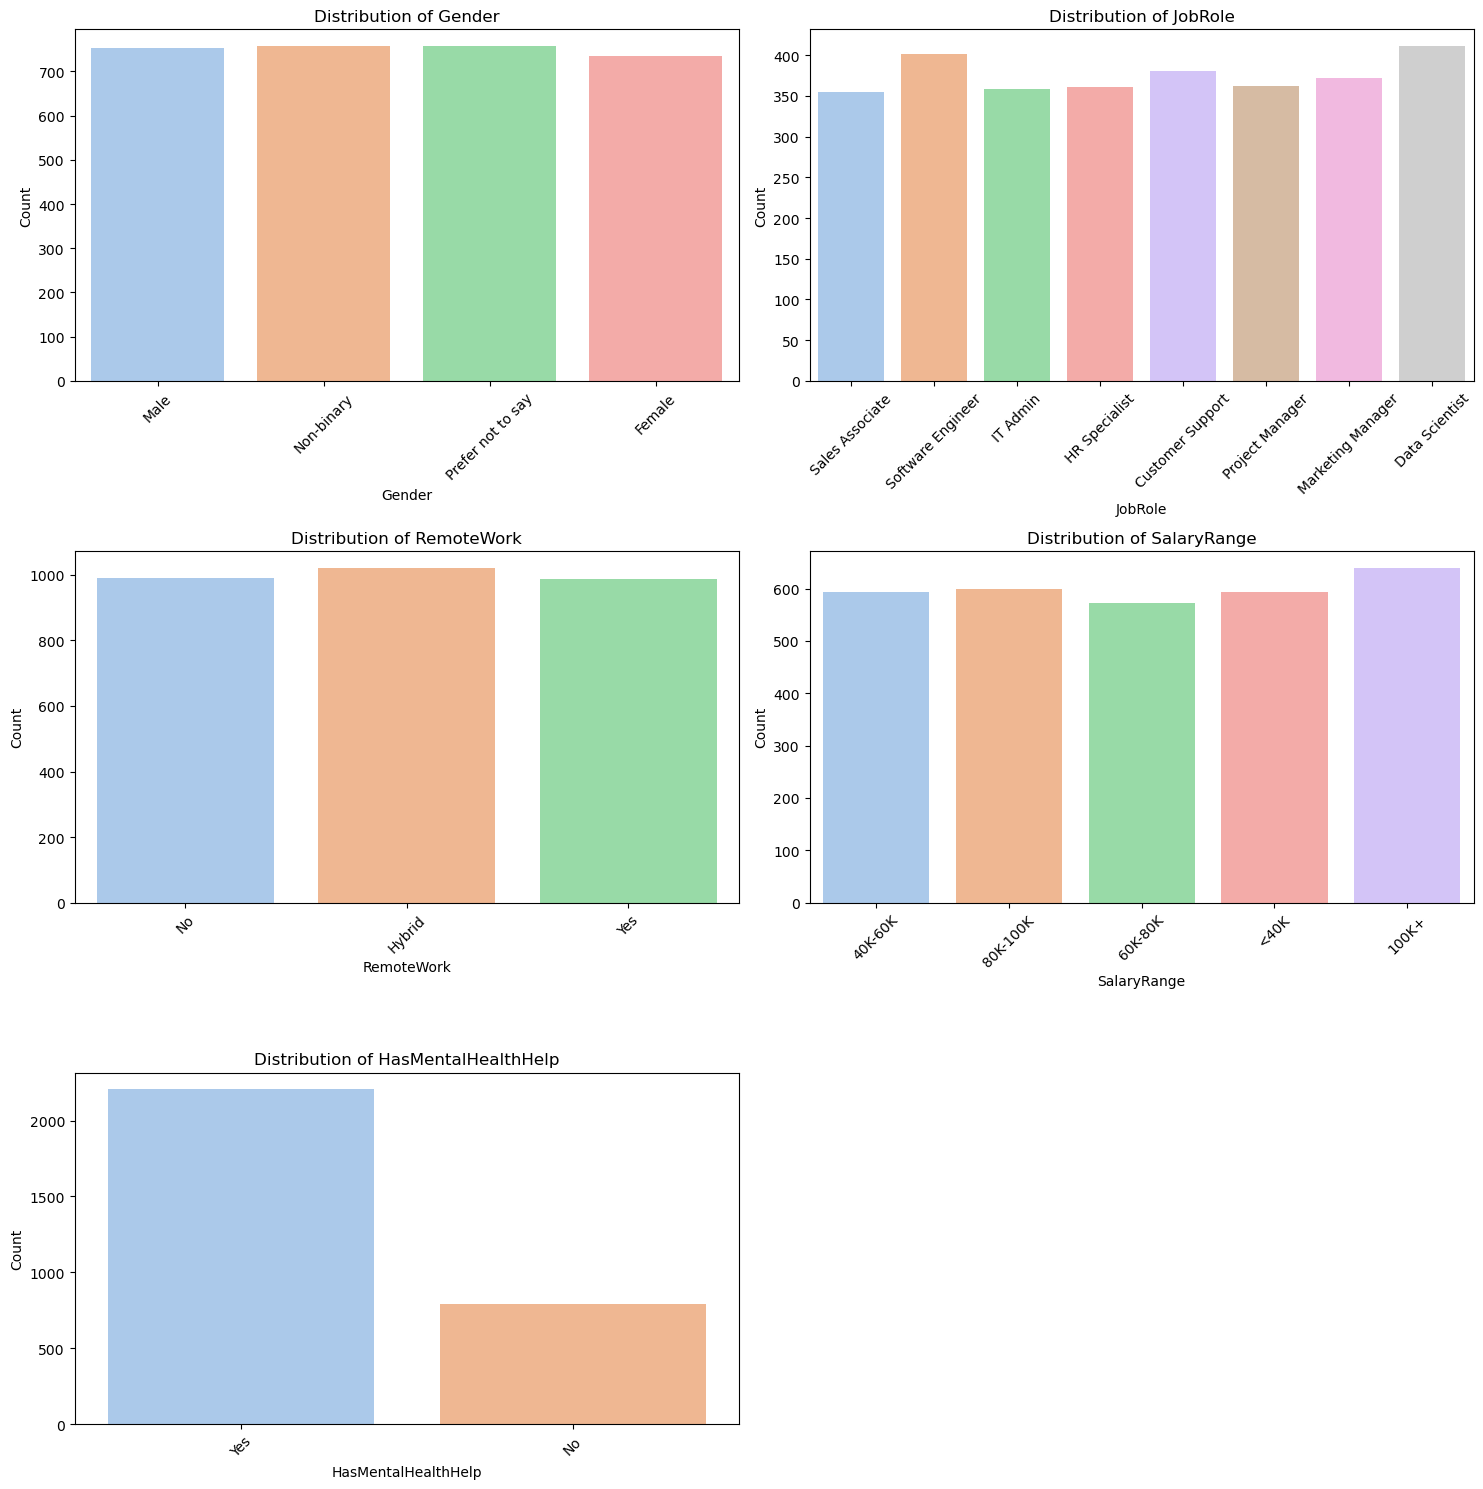

In [ ]:
# Calculate grid size for subplots
num_cols = len(cat_cols)
n_rows = math.ceil(num_cols / 2) 
n_cols = 2

# Create the figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Loop through categorical columns
for i, col in enumerate(cat_cols):
    # Plotting without 'hue' to see the overall frequency of each category
    sns.countplot(data=df, x=col, hue=col, legend=False, ax=axes[i], palette='pastel')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylabel('Count')

# Remove any empty subplots
for i in range(num_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

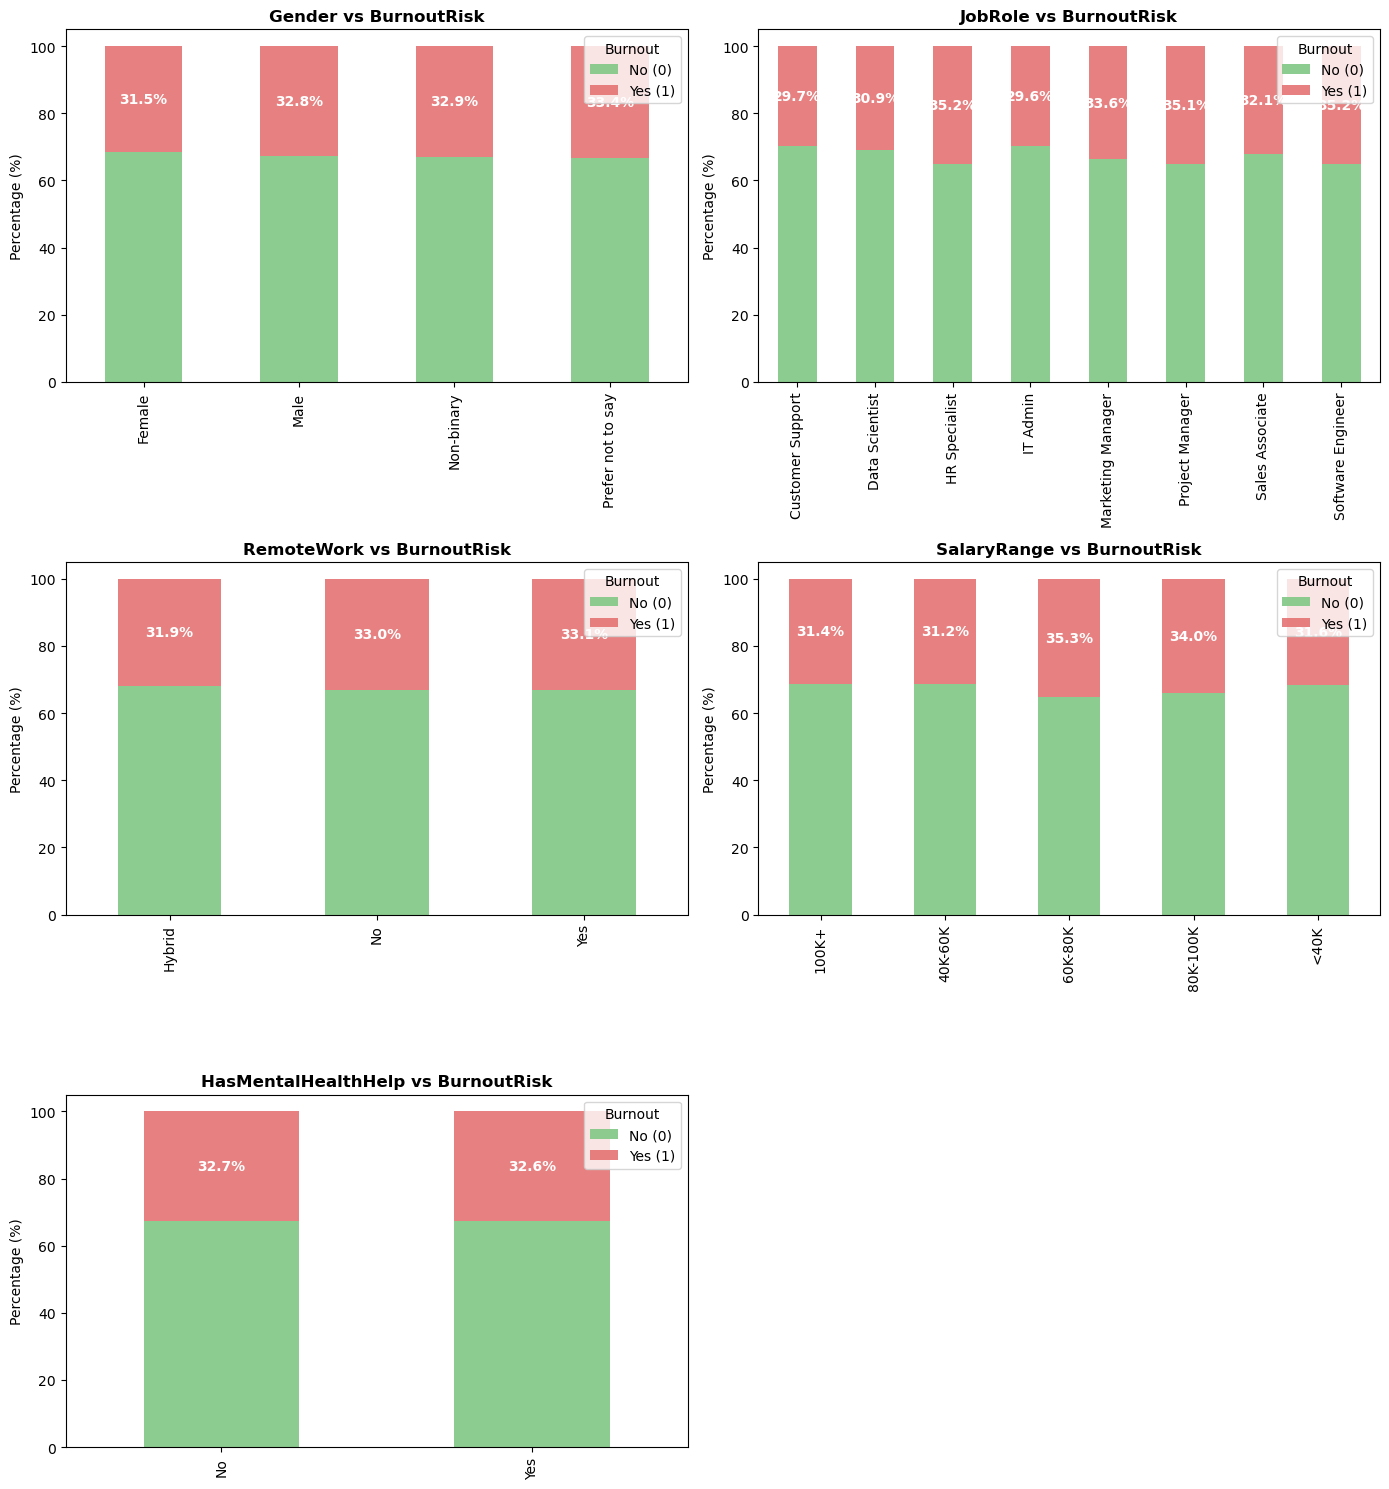

In [ ]:
target = 'BurnoutRisk'

# Calculate layout dynamically
n_cols = 2
n_rows = (len(cat_cols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
axes = axes.flatten() # Flatten for easy iteration

for i, col in enumerate(cat_cols):
    ax = axes[i]

    # Create Cross Tabulation (Proportions)
    ct = pd.crosstab(df[col], df[target], normalize='index') * 100

    ct.plot(kind='bar', stacked=True, ax=ax, color=['#81c784', '#e57373'], alpha=0.9)

    # Formatting
    ax.set_title(f"{col} vs BurnoutRisk", fontsize=12, fontweight='bold')
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel("")
    ax.legend(title='Burnout', labels=['No (0)', 'Yes (1)'], loc='upper right')

    # Annotate bars with the % of Burnout (The Red Bar)
    for n, x in enumerate([*ct.index.values]):
        burnout_pct = ct.loc[x, 1]
        ax.text(n, burnout_pct/2 + ct.loc[x, 0], f"{burnout_pct:.1f}%",
                ha='center', va='center', color='white', fontweight='bold')

# Remove empty subplots if odd number of features
if len(cat_cols) < len(axes):
    for j in range(len(cat_cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

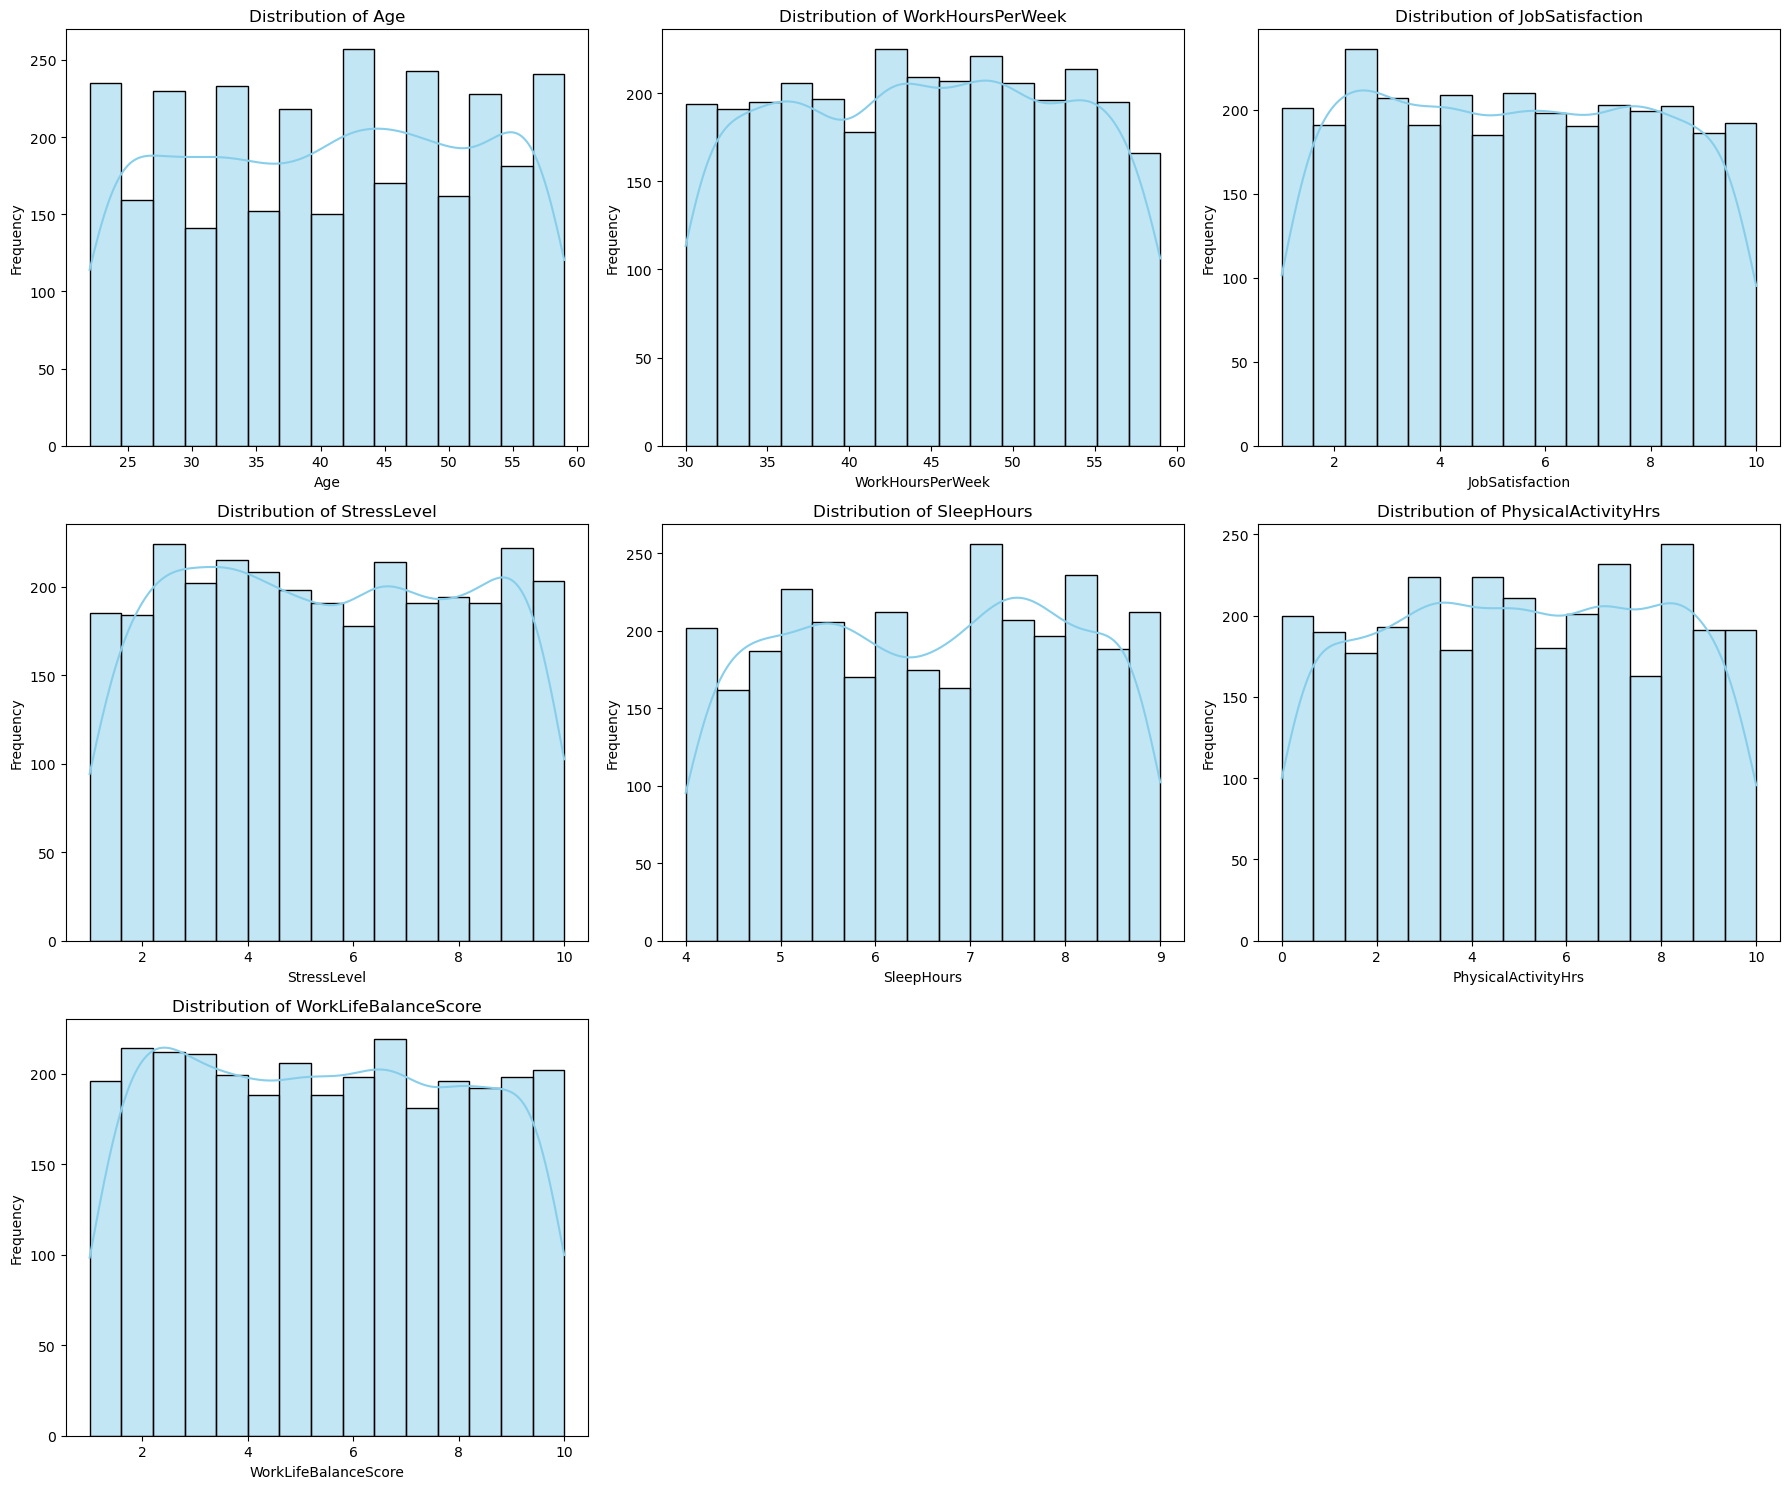

In [ ]:
# Calculate grid size for subplots
num_cols = ['Age', 'WorkHoursPerWeek', 'JobSatisfaction', 'StressLevel', 'SleepHours', 'PhysicalActivityHrs', 'WorkLifeBalanceScore']
num_plots = len(num_cols)
n_rows = math.ceil(num_plots / 3)  # Arrange in 3 columns
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

# Loop through numerical columns
for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i], color='skyblue', edgecolor='black', bins=15)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

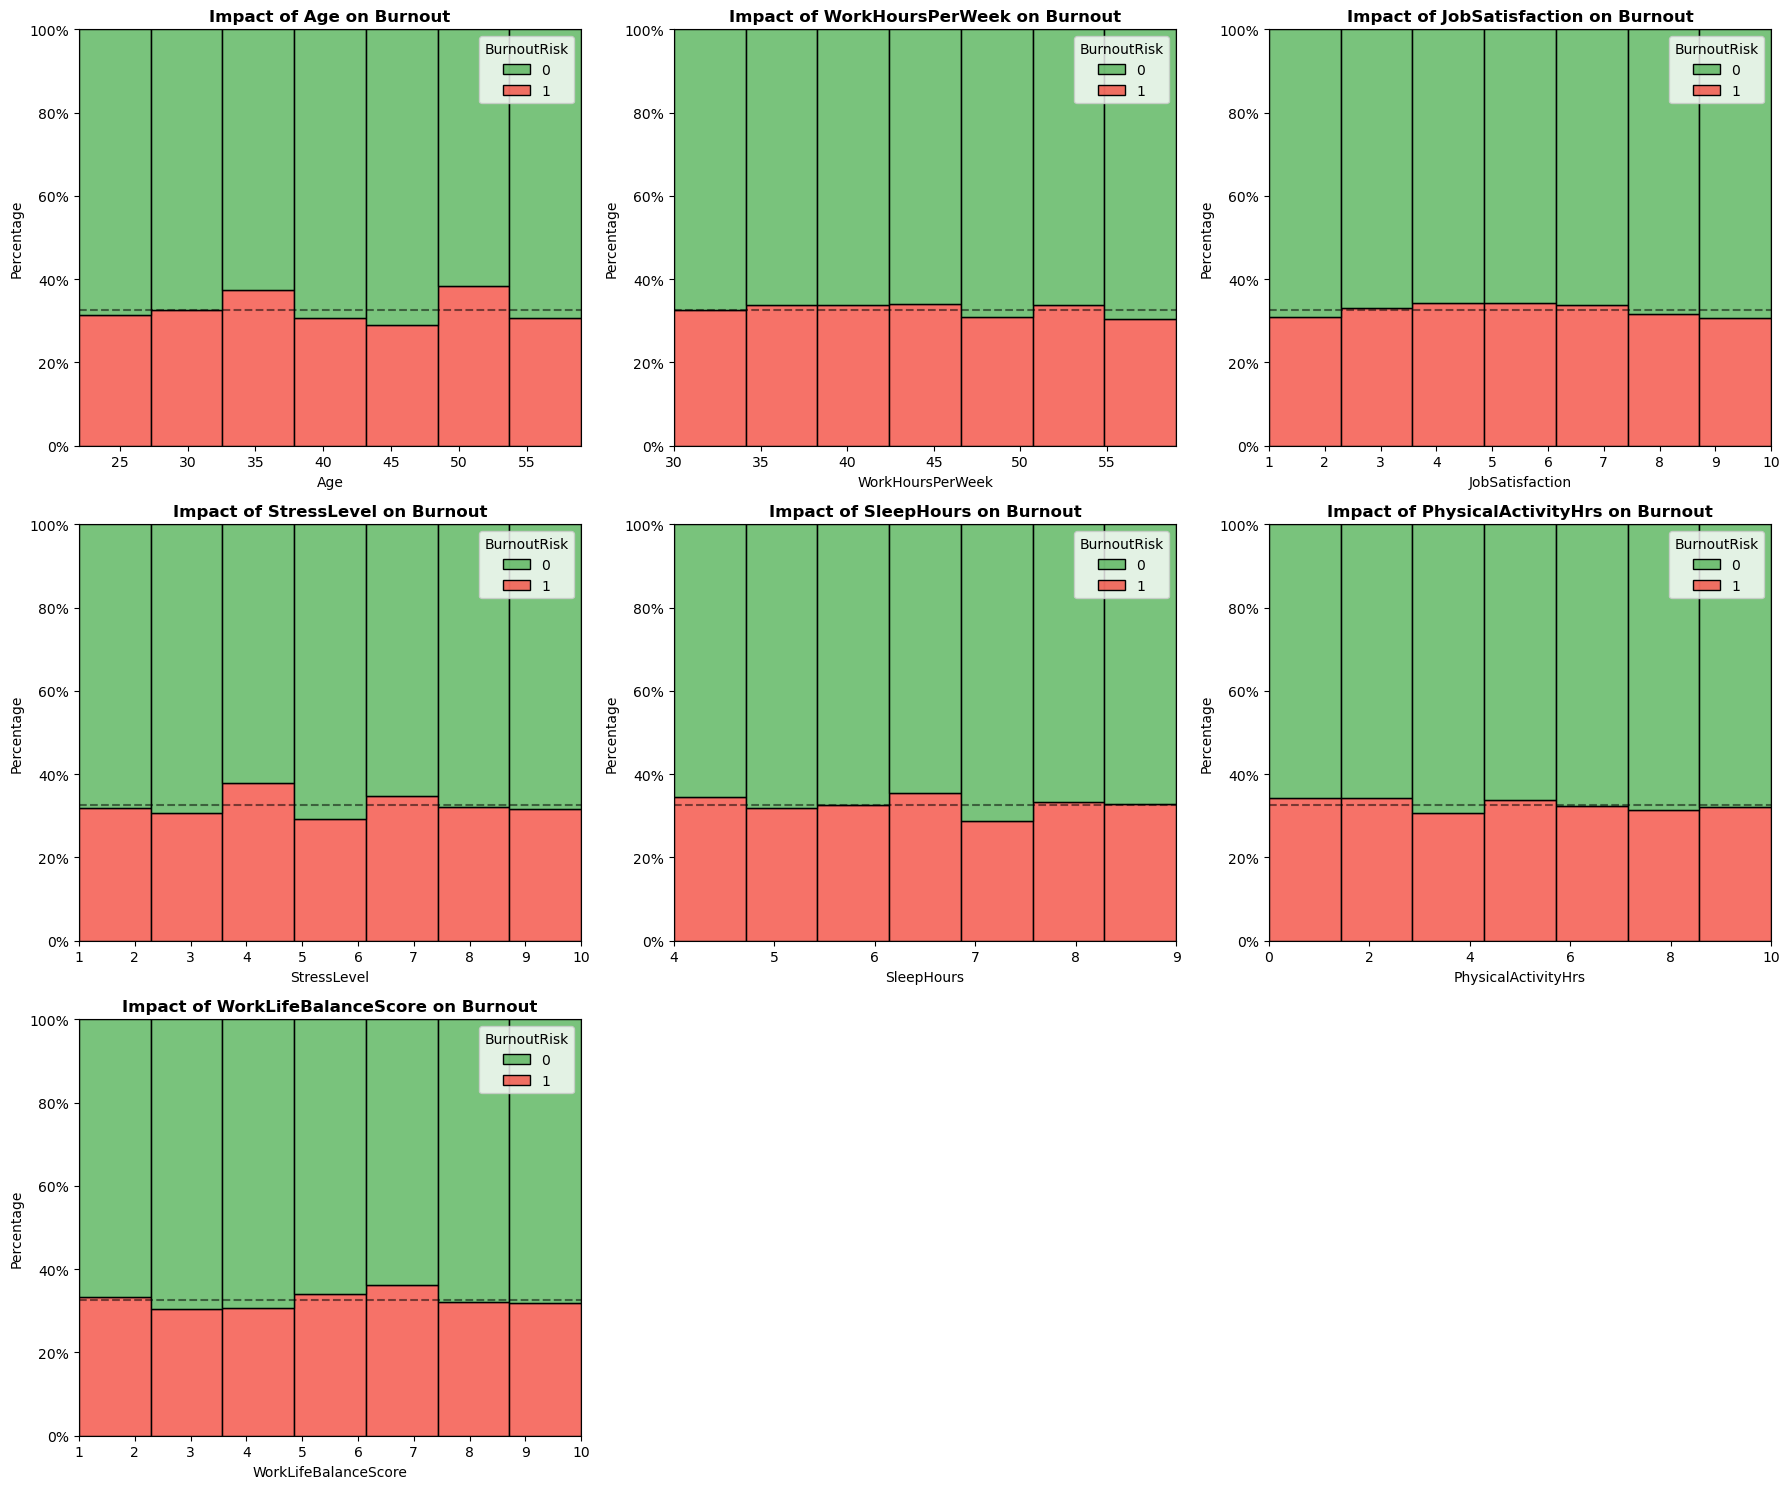

In [ ]:
# Calculate grid size
num_cols = ['Age', 'WorkHoursPerWeek', 'JobSatisfaction', 'StressLevel', 'SleepHours', 'PhysicalActivityHrs', 'WorkLifeBalanceScore']

num_plots = len(num_cols)
n_cols = 3
n_rows = math.ceil(num_plots / n_cols)

# Create the figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

# Loop through numerical columns
for i, col in enumerate(num_cols):

    sns.histplot(
        data=df,
        x=col,
        hue='BurnoutRisk',
        multiple='fill',      
        kde=False,           
        element='bars',      
        stat='probability',  
        palette=['#4caf50', '#f44336'], # Green (No), Red (Yes)
        ax=axes[i],
        bins=7              
    )

    axes[i].set_title(f'Impact of {col} on Burnout', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percentage')

    # Format Y-axis as 0% - 100%
    axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # Optional: Add a reference line for the average burnout rate
    avg_burnout = df['BurnoutRisk'].mean()
    axes[i].axhline(avg_burnout, color='black', linestyle='--', alpha=0.5, label='Global Avg')

# Remove empty subplots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Final Discretization and Exporting Processed CSV


--- Analyzing: Age vs BurnoutRisk ---
Optimal Bins (Leaves): 4
Suggested Thresholds: [40.5, 48.5, 56.5]

Threshold Candidates per K:
  K=2: [56.5]
  K=3: [48.5, 56.5]
  K=4: [40.5, 48.5, 56.5]
  K=5: [40.5, 48.5, 52.5, 56.5]


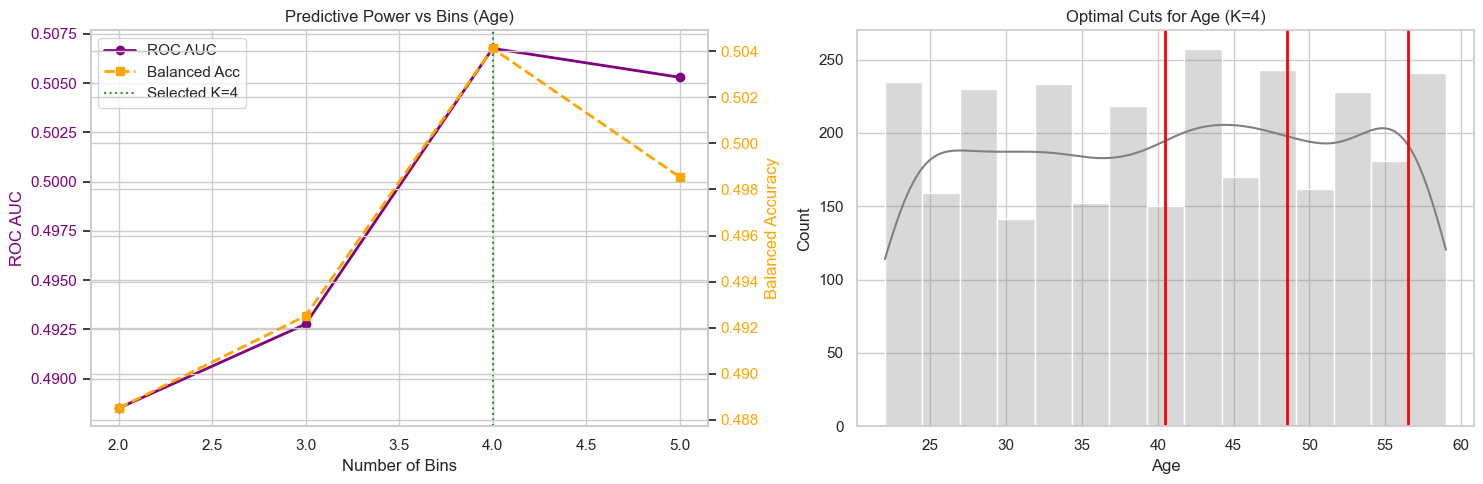


--- Analyzing: WorkHoursPerWeek vs BurnoutRisk ---
Optimal Bins (Leaves): 2
Suggested Thresholds: [55.5]

Threshold Candidates per K:
  K=2: [55.5]
  K=3: [40.5, 55.5]
  K=4: [37.5, 40.5, 55.5]
  K=5: [37.5, 40.5, 43.5, 55.5]
  K=6: [37.5, 40.5, 43.5, 47.5, 55.5]


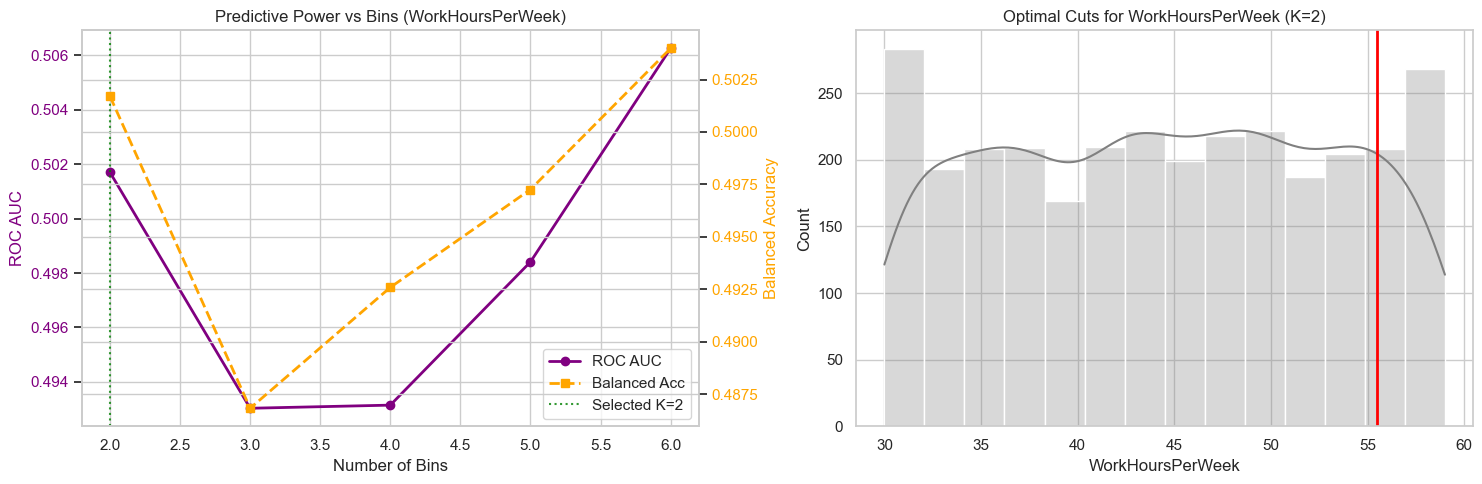


--- Analyzing: JobSatisfaction vs BurnoutRisk ---
Optimal Bins (Leaves): 3
Suggested Thresholds: [2.72, 7.74]

Threshold Candidates per K:
  K=2: [7.74]
  K=3: [2.72, 7.74]
  K=4: [2.72, 7.74, 8.49]
  K=5: [2.72, 7.06, 7.74, 8.49]


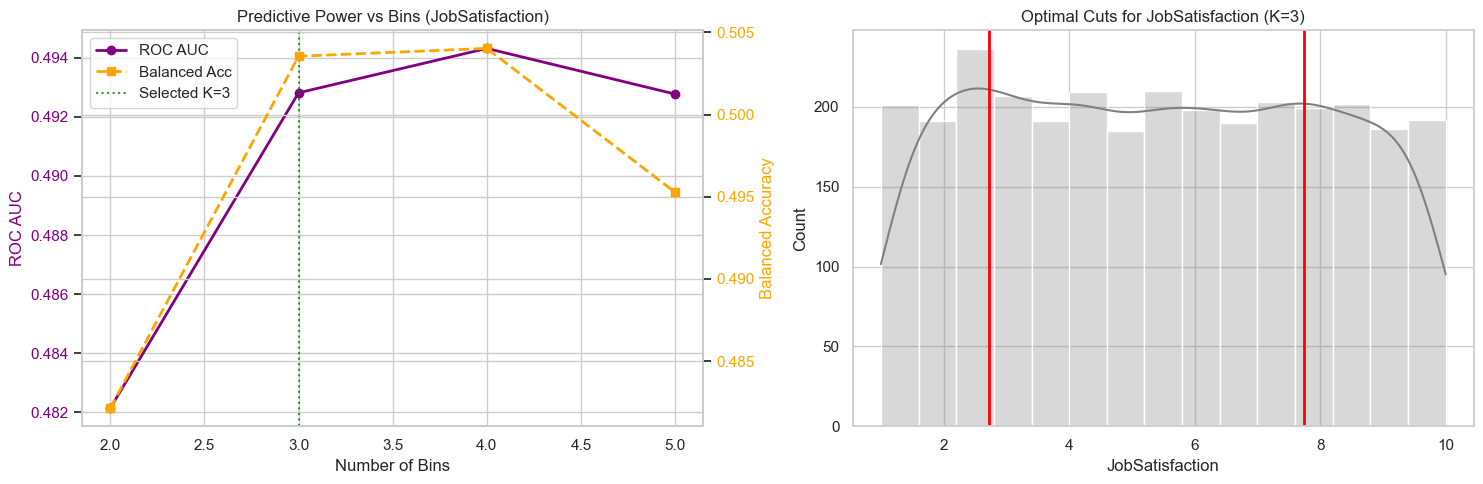


--- Analyzing: StressLevel vs BurnoutRisk ---
Optimal Bins (Leaves): 2
Suggested Thresholds: [1.66]

Threshold Candidates per K:
  K=2: [1.66]
  K=3: [1.66, 7.88]
  K=4: [1.66, 7.88, 8.88]
  K=5: [1.66, 6.32, 7.88, 8.88]


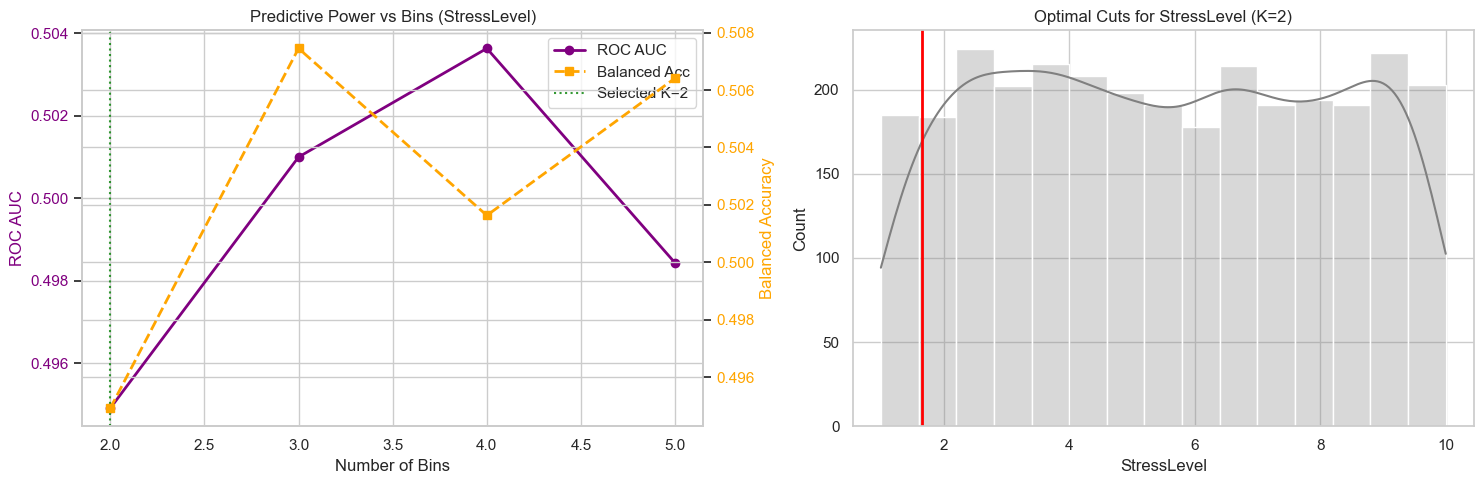


--- Analyzing: SleepHours vs BurnoutRisk ---
Optimal Bins (Leaves): 2
Suggested Thresholds: [4.45]

Threshold Candidates per K:
  K=2: [4.45]
  K=3: [4.45, 4.85]
  K=4: [4.45, 4.85, 6.95]
  K=5: [4.45, 4.85, 6.95, 7.55]


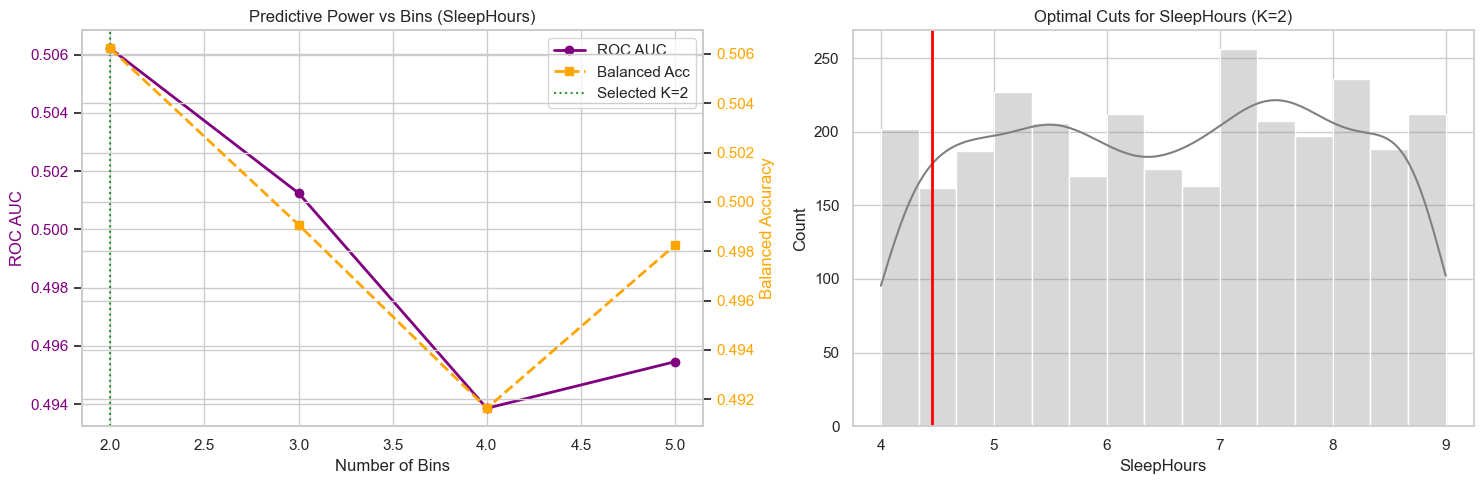


--- Analyzing: PhysicalActivityHrs vs BurnoutRisk ---
Optimal Bins (Leaves): 3
Suggested Thresholds: [0.45, 1.65]

Threshold Candidates per K:
  K=2: [0.45]
  K=3: [0.45, 1.65]
  K=4: [0.45, 1.65, 8.05]
  K=5: [0.45, 1.65, 5.05, 8.05]


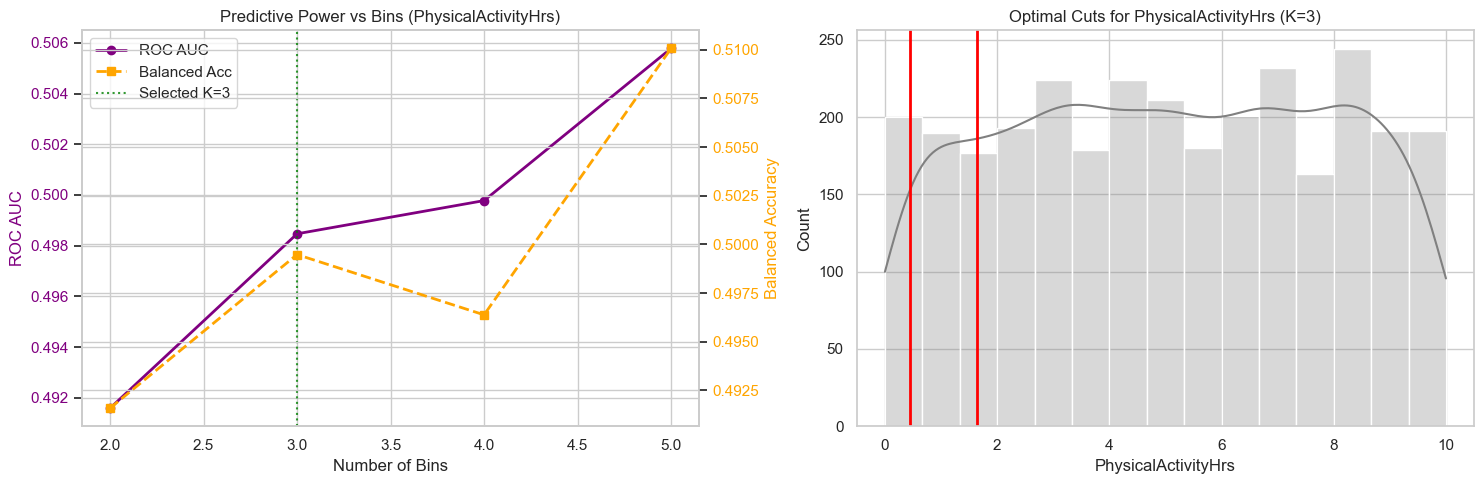


--- Analyzing: WorkLifeBalanceScore vs BurnoutRisk ---
Optimal Bins (Leaves): 5
Suggested Thresholds: [2.81, 4.27, 6.69, 7.77]

Threshold Candidates per K:
  K=2: [4.27]
  K=3: [2.81, 4.27]
  K=4: [2.81, 4.27, 7.77]
  K=5: [2.81, 4.27, 6.69, 7.77]


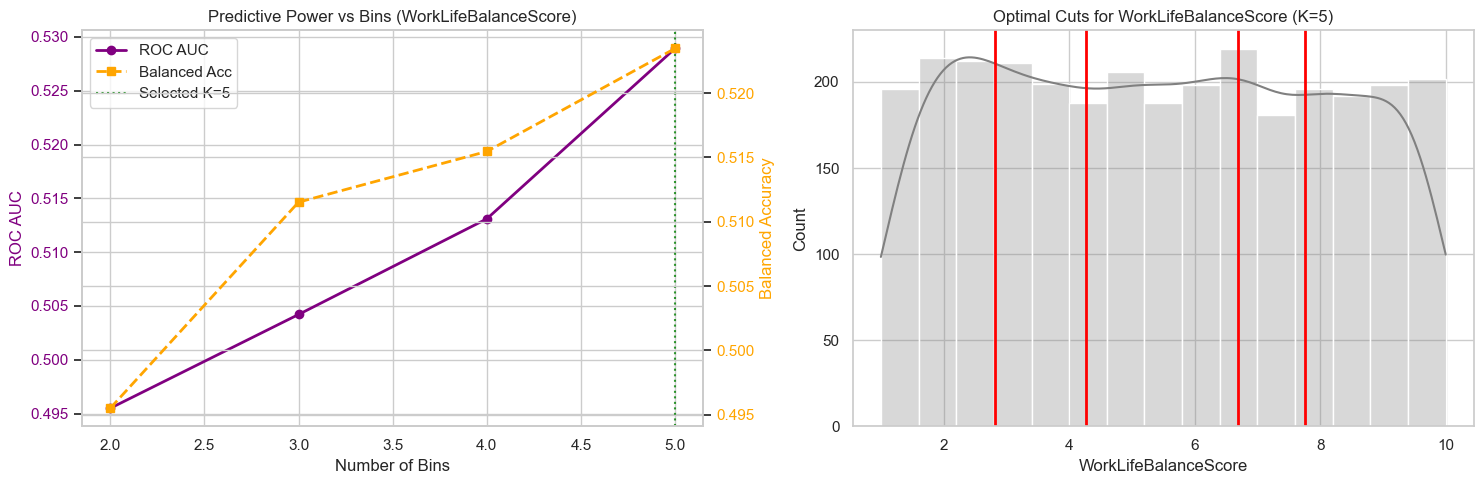

In [ ]:
def find_optimal_bins(df, feature_col, target_col, max_k=5, min_bin_pct=0.05):
    """
    Uses a Decision Tree to find the optimal cuts.
    Returns: Best K, Thresholds, Results (AUC), Results (Balanced Acc), and Map of all thresholds

    Parameters:
    - min_bin_pct: Minimum percentage of data required in a bin (default 5%).
                   Prevents 'fringe' bins like [1.06, 9.89] on 1-10 data.
    """
    X = df[[feature_col]]
    y = df[target_col]

    # Calculate integer min samples based on percentage
    min_samples = int(len(df) * min_bin_pct)

    best_score = -np.inf
    best_k = 2
    results_auc = {}
    results_bal_acc = {}
    all_thresholds_map = {}

    # Iterate through allowed number of bins (leaves)
    for k in range(2, max_k + 1):
        tree = DecisionTreeClassifier(
            max_leaf_nodes=k,
            class_weight='balanced',
            min_samples_leaf=min_samples,
            random_state=42
        )

        # Metric 1: ROC AUC (Used for decision making)
        scores_auc = cross_val_score(tree, X, y, cv=5, scoring='roc_auc')
        results_auc[k] = np.mean(scores_auc)

        # Metric 2: Balanced Accuracy (For visualization context)
        scores_bal = cross_val_score(tree, X, y, cv=5, scoring='balanced_accuracy')
        results_bal_acc[k] = np.mean(scores_bal)

        # Capture thresholds for this specific K (fit on full data)
        tree.fit(X, y)
        k_thresholds = tree.tree_.threshold[tree.tree_.threshold != -2]
        all_thresholds_map[k] = sorted(k_thresholds)

    # --- SMART SELECTION HEURISTIC ---
    # We continue to use ROC AUC for the actual selection as it's more robust
    max_score = max(results_auc.values())

    # Prefer fewer bins if performance is close (within 1% of max score)
    sorted_k = sorted(results_auc.keys())
    selected_k = sorted_k[-1] # Default to max

    for k in sorted_k:
        if results_auc[k] > (max_score - 0.01):
            selected_k = k
            break

    # Retrain final model on full data to get thresholds (redundant but clean for return)
    final_tree = DecisionTreeClassifier(
        max_leaf_nodes=selected_k,
        class_weight='balanced',
        min_samples_leaf=min_samples,
        random_state=42
    )
    final_tree.fit(X, y)

    # Extract thresholds from the tree structure
    thresholds = final_tree.tree_.threshold[final_tree.tree_.threshold != -2]
    thresholds = sorted(thresholds)

    return selected_k, thresholds, results_auc, results_bal_acc, all_thresholds_map

def analyze_supervised_binning(df, num_cols, target_col, max_k=6, min_bin_pct=0.05):
    sns.set_theme(style="whitegrid")

    # Handle single string input so user can run one feature at a time
    if isinstance(num_cols, str):
        num_cols = [num_cols]

    for col in num_cols:
        print(f"\n--- Analyzing: {col} vs {target_col} ---")

        # Pass the max_k and min_bin_pct arguments down to the logic function
        best_k, thresholds, scores_auc, scores_bal, all_thresholds = find_optimal_bins(
            df, col, target_col, max_k=max_k, min_bin_pct=min_bin_pct
        )

        print(f"Optimal Bins (Leaves): {best_k}")
        print(f"Suggested Thresholds: {[round(t, 2) for t in thresholds]}")

        print("\nThreshold Candidates per K:")
        for k, thres in all_thresholds.items():
            formatted_t = [round(t, 2) for t in thres]
            print(f"  K={k}: {formatted_t}")

        # --- PLOTTING ---
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Left: Score Evolution (Dual Metrics with Dual Axes)
        ax1 = axes[0]
        k_values = list(scores_auc.keys())

        # Primary Axis (Left) - ROC AUC
        color_auc = 'purple'
        ax1.set_xlabel('Number of Bins')
        ax1.set_ylabel('ROC AUC', color=color_auc)
        line1 = ax1.plot(k_values, list(scores_auc.values()), marker='o', linewidth=2, color=color_auc, label='ROC AUC')
        ax1.tick_params(axis='y', labelcolor=color_auc)

        # Secondary Axis (Right) - Balanced Accuracy
        ax2_twin = ax1.twinx()  # Create a twin axis sharing the x-axis
        color_bal = 'orange'
        ax2_twin.set_ylabel('Balanced Accuracy', color=color_bal)
        line2 = ax2_twin.plot(k_values, list(scores_bal.values()), marker='s', linewidth=2, color=color_bal, linestyle='--', label='Balanced Acc')
        ax2_twin.tick_params(axis='y', labelcolor=color_bal)

        ax1.set_title(f'Predictive Power vs Bins ({col})')

        # Highlight selected K on the primary axis
        line3 = ax1.axvline(best_k, color='green', linestyle=':', alpha=0.8, label=f'Selected K={best_k}')

        # Combine legends from both axes
        lines = line1 + line2 + [line3]
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='best')

        # Right: Histogram with Cuts
        ax2 = axes[1]
        sns.histplot(data=df, x=col, kde=True, ax=ax2, color='gray', alpha=0.3)
        ax2.set_title(f'Optimal Cuts for {col} (K={best_k})')

        for t in thresholds:
            ax2.axvline(t, color='red', linestyle='-', linewidth=2, label=f'Cut: {t:.2f}')

        plt.tight_layout()
        plt.show()

analyze_supervised_binning(df, 'Age', target_col='BurnoutRisk', max_k=5, min_bin_pct=0.05)
analyze_supervised_binning(df, 'WorkHoursPerWeek', target_col='BurnoutRisk', max_k=6, min_bin_pct=0.08)
analyze_supervised_binning(df, 'JobSatisfaction', target_col='BurnoutRisk', max_k=5, min_bin_pct=0.08)
analyze_supervised_binning(df, 'StressLevel', target_col='BurnoutRisk', max_k=5, min_bin_pct=0.065)
analyze_supervised_binning(df, 'SleepHours', target_col='BurnoutRisk', max_k=5, min_bin_pct=0.04)
analyze_supervised_binning(df, 'PhysicalActivityHrs', target_col='BurnoutRisk', max_k=5, min_bin_pct=0.04)
analyze_supervised_binning(df, 'WorkLifeBalanceScore', target_col='BurnoutRisk', max_k=5, min_bin_pct=0.05)

In [ ]:
def apply_custom_binning(df):
    """
    Applies specific thresholds and custom labels for each feature.
    """

    binning_config = {
        'Age': {
            'cuts': [40.5, 48.5, 56.5],
            # 3 cuts = 4 bins
            'labels': ['1.Young', '2.Mid-Life', '3.Senior', '4.Elder']
        },
        'WorkHoursPerWeek': {
            'cuts': [55.5],
            # 1 cut = 2 bins
            'labels': ['1.Standard Load', '2.Overworked']
        },
        'JobSatisfaction': {
            'cuts': [2.72, 7.74],
            # 2 cuts = 3 bins
            'labels': ['1.Unhappy', '2.Neutral', '3.Happy']
        },
        'StressLevel': {
            'cuts': [1.66, 7.88],
            # 2 cuts = 3 bins
            'labels': ['1.Low', '2.Moderate', '3.High']
        },
        'SleepHours': {
            'cuts': [4.45],
            # 1 cut = 2 bins
            'labels': ['1.Sleep Deprived', '2.Well Rested']
        },
        'PhysicalActivityHrs': {
            'cuts': [0.45, 1.65, 5.05, 8.05],
            # 4 cuts = 5 bins
            'labels': ['1.Sedentary', '2.Light', '3.Moderate', '4.Active', '5.Athlete']
        },
        'WorkLifeBalanceScore': {
            'cuts': [2.81, 4.27, 6.69, 7.77],
            # 4 cuts = 5 bins
            'labels': ['1.Terrible', '2.Poor', '3.Fair', '4.Good', '5.Excellent']
        }
    }

    df_binned = df.copy()

    print("\n--- Applying Binning & Verifying Ranges ---")

    for col, config in binning_config.items():
        if col not in df.columns:
            continue

        cuts = config['cuts']
        labels = config['labels']

        if len(labels) != len(cuts) + 1:
            print(f"ERROR: {col} has {len(cuts)} cuts but {len(labels)} labels. Needs {len(cuts)+1}.")
            continue

        edges = [-np.inf] + cuts + [np.inf]

        new_col = f"{col}_Cat"
        df_binned[new_col] = pd.cut(
            df[col],
            bins=edges,
            labels=labels,
            include_lowest=True
        )

        # Print Codebook (Range -> Label map)
        print(f"\nFeature: {col}")
        for i, label in enumerate(labels):
            lower = edges[i]
            upper = edges[i+1]
            lower_str = "-inf" if lower == -np.inf else f"{lower}"
            upper_str = "inf" if upper == np.inf else f"{upper}"
            print(f"  - '{label}': \t{lower_str} to {upper_str}")

    return df_binned


final_df = apply_custom_binning(df)

print("\n--- Data Preview ---")
cols = ['Age', 'Age_Cat', 'JobSatisfaction', 'JobSatisfaction_Cat']
print(final_df[cols].head(10))


--- Applying Binning & Verifying Ranges ---

Feature: Age
  - '1.Young': 	-inf to 40.5
  - '2.Mid-Life': 	40.5 to 48.5
  - '3.Senior': 	48.5 to 56.5
  - '4.Elder': 	56.5 to inf

Feature: WorkHoursPerWeek
  - '1.Standard Load': 	-inf to 55.5
  - '2.Overworked': 	55.5 to inf

Feature: JobSatisfaction
  - '1.Unhappy': 	-inf to 2.72
  - '2.Neutral': 	2.72 to 7.74
  - '3.Happy': 	7.74 to inf

Feature: StressLevel
  - '1.Low': 	-inf to 1.66
  - '2.Moderate': 	1.66 to 7.88
  - '3.High': 	7.88 to inf

Feature: SleepHours
  - '1.Sleep Deprived': 	-inf to 4.45
  - '2.Well Rested': 	4.45 to inf

Feature: PhysicalActivityHrs
  - '1.Sedentary': 	-inf to 0.45
  - '2.Light': 	0.45 to 1.65
  - '3.Moderate': 	1.65 to 5.05
  - '4.Active': 	5.05 to 8.05
  - '5.Athlete': 	8.05 to inf

Feature: WorkLifeBalanceScore
  - '1.Terrible': 	-inf to 2.81
  - '2.Poor': 	2.81 to 4.27
  - '3.Fair': 	4.27 to 6.69
  - '4.Good': 	6.69 to 7.77
  - '5.Excellent': 	7.77 to inf

--- Data Preview ---
   Age     Age_Cat  Job

In [14]:
print("\nStarting discretization and preparation of variables...")

# Target variable
final_df['BurnoutRisk_label'] = final_df['BurnoutRisk'].apply(lambda x: 'Yes' if x == 1 else 'No')

# -----------------------------------------------------------------------------
# Dataframe creation for the Bayesian network
# -----------------------------------------------------------------------------
final_columns = [
    'Age_Cat', 'Gender', 'JobRole', 'WorkHoursPerWeek_Cat', 'RemoteWork',
    'JobSatisfaction_Cat', 'SleepHours_Cat', 'StressLevel_Cat',
    'PhysicalActivityHrs_Cat', 'SalaryRange', 'WorkLifeBalanceScore_Cat',
    'HasMentalHealthHelp', 'BurnoutRisk_label'
]
df_bn = final_df[final_columns].copy()

# Rename columns for clarity
df_bn = df_bn.rename(columns={
    'Age_Cat': 'Age',
    'WorkHoursPerWeek_Cat': 'WorkHours',
    'StressLevel_Cat': 'Stress',
    'JobSatisfaction_Cat': 'JobSatisfaction',
    'SleepHours_Cat': 'SleepHours',
    'PhysicalActivityHrs_Cat': 'PhysicalActivity',
    'WorkLifeBalanceScore_Cat': 'WorkLifeBalance',
    'BurnoutRisk_label': 'BurnoutRisk'
})

print("\nProcess completed.")
print("\nFirst 5 rows of the final cleaned dataset:")
print(df_bn.head())
print(f"\nThe final dataset has {df_bn.shape[0]} rows and {df_bn.shape[1]} columns.")

# Save the final file
df_bn.to_csv('burnout_dataset_final.csv', index=False)
print("\nDataset processed and saved as 'burnout_dataset_final.csv'")


Starting discretization and preparation of variables...

Process completed.

First 5 rows of the final cleaned dataset:
          Age      Gender            JobRole        WorkHours RemoteWork  \
0    3.Senior        Male    Sales Associate  1.Standard Load         No   
1     1.Young        Male  Software Engineer     2.Overworked     Hybrid   
2     1.Young  Non-binary           IT Admin     2.Overworked     Hybrid   
3  2.Mid-Life        Male      HR Specialist  1.Standard Load        Yes   
4     1.Young        Male   Customer Support  1.Standard Load        Yes   

  JobSatisfaction        SleepHours      Stress PhysicalActivity SalaryRange  \
0       2.Neutral     2.Well Rested      3.High         4.Active     40K-60K   
1       1.Unhappy     2.Well Rested  2.Moderate        5.Athlete    80K-100K   
2       2.Neutral     2.Well Rested  2.Moderate        5.Athlete    80K-100K   
3       2.Neutral     2.Well Rested  2.Moderate         4.Active     60K-80K   
4       1.Unhappy  1.S

# Baysian Network Structure Design
a bit of exploring final dataset, then finding proper network structure using statistical analysis and some algorithms

In [15]:
try:
    df = pd.read_csv('burnout_dataset_final.csv')
    print("Dataset processed ('burnout_dataset_final.csv') loaded successfully.")
except FileNotFoundError:
    print("Error: File 'burnout_dataset_final.csv' not found.")
    exit()

Dataset processed ('burnout_dataset_final.csv') loaded successfully.


## Exploration

In [16]:
print("# **Categorical Feature Exploration**\n")
print("This section provides an overview of the categorical features in the dataset, including the number of unique categories and detailed value counts for each.\n")

# Filter for object columns and convert to markdown table
nunique_data = df.select_dtypes(include='object').nunique().reset_index()
nunique_data.columns = ['Feature', 'Unique Categories']

# Add a new column for 'Categories'
categories_list = []
for col in nunique_data['Feature']:
    categories = df[col].unique().tolist()
    categories_list.append(str(categories))
nunique_data['Categories'] = categories_list

# Display as pandas DataFrame instead of markdown table
nunique_data

# **Categorical Feature Exploration**

This section provides an overview of the categorical features in the dataset, including the number of unique categories and detailed value counts for each.



,Feature,Unique Categories,Categories
0,Age,4,"['3.Senior', '1.Young', '2.Mid-Life', '4.Elder']"
1,Gender,4,"['Male', 'Non-binary', 'Prefer not to say', 'F..."
2,JobRole,8,"['Sales Associate', 'Software Engineer', 'IT A..."
3,WorkHours,2,"['1.Standard Load', '2.Overworked']"
4,RemoteWork,3,"['No', 'Hybrid', 'Yes']"
5,JobSatisfaction,3,"['2.Neutral', '1.Unhappy', '3.Happy']"
6,SleepHours,2,"['2.Well Rested', '1.Sleep Deprived']"
7,Stress,3,"['3.High', '2.Moderate', '1.Low']"
8,PhysicalActivity,5,"['4.Active', '5.Athlete', '3.Moderate', '1.Sed..."
9,SalaryRange,5,"['40K-60K', '80K-100K', '60K-80K', '<40K', '10..."


About to create a grid of 4x3 plots...


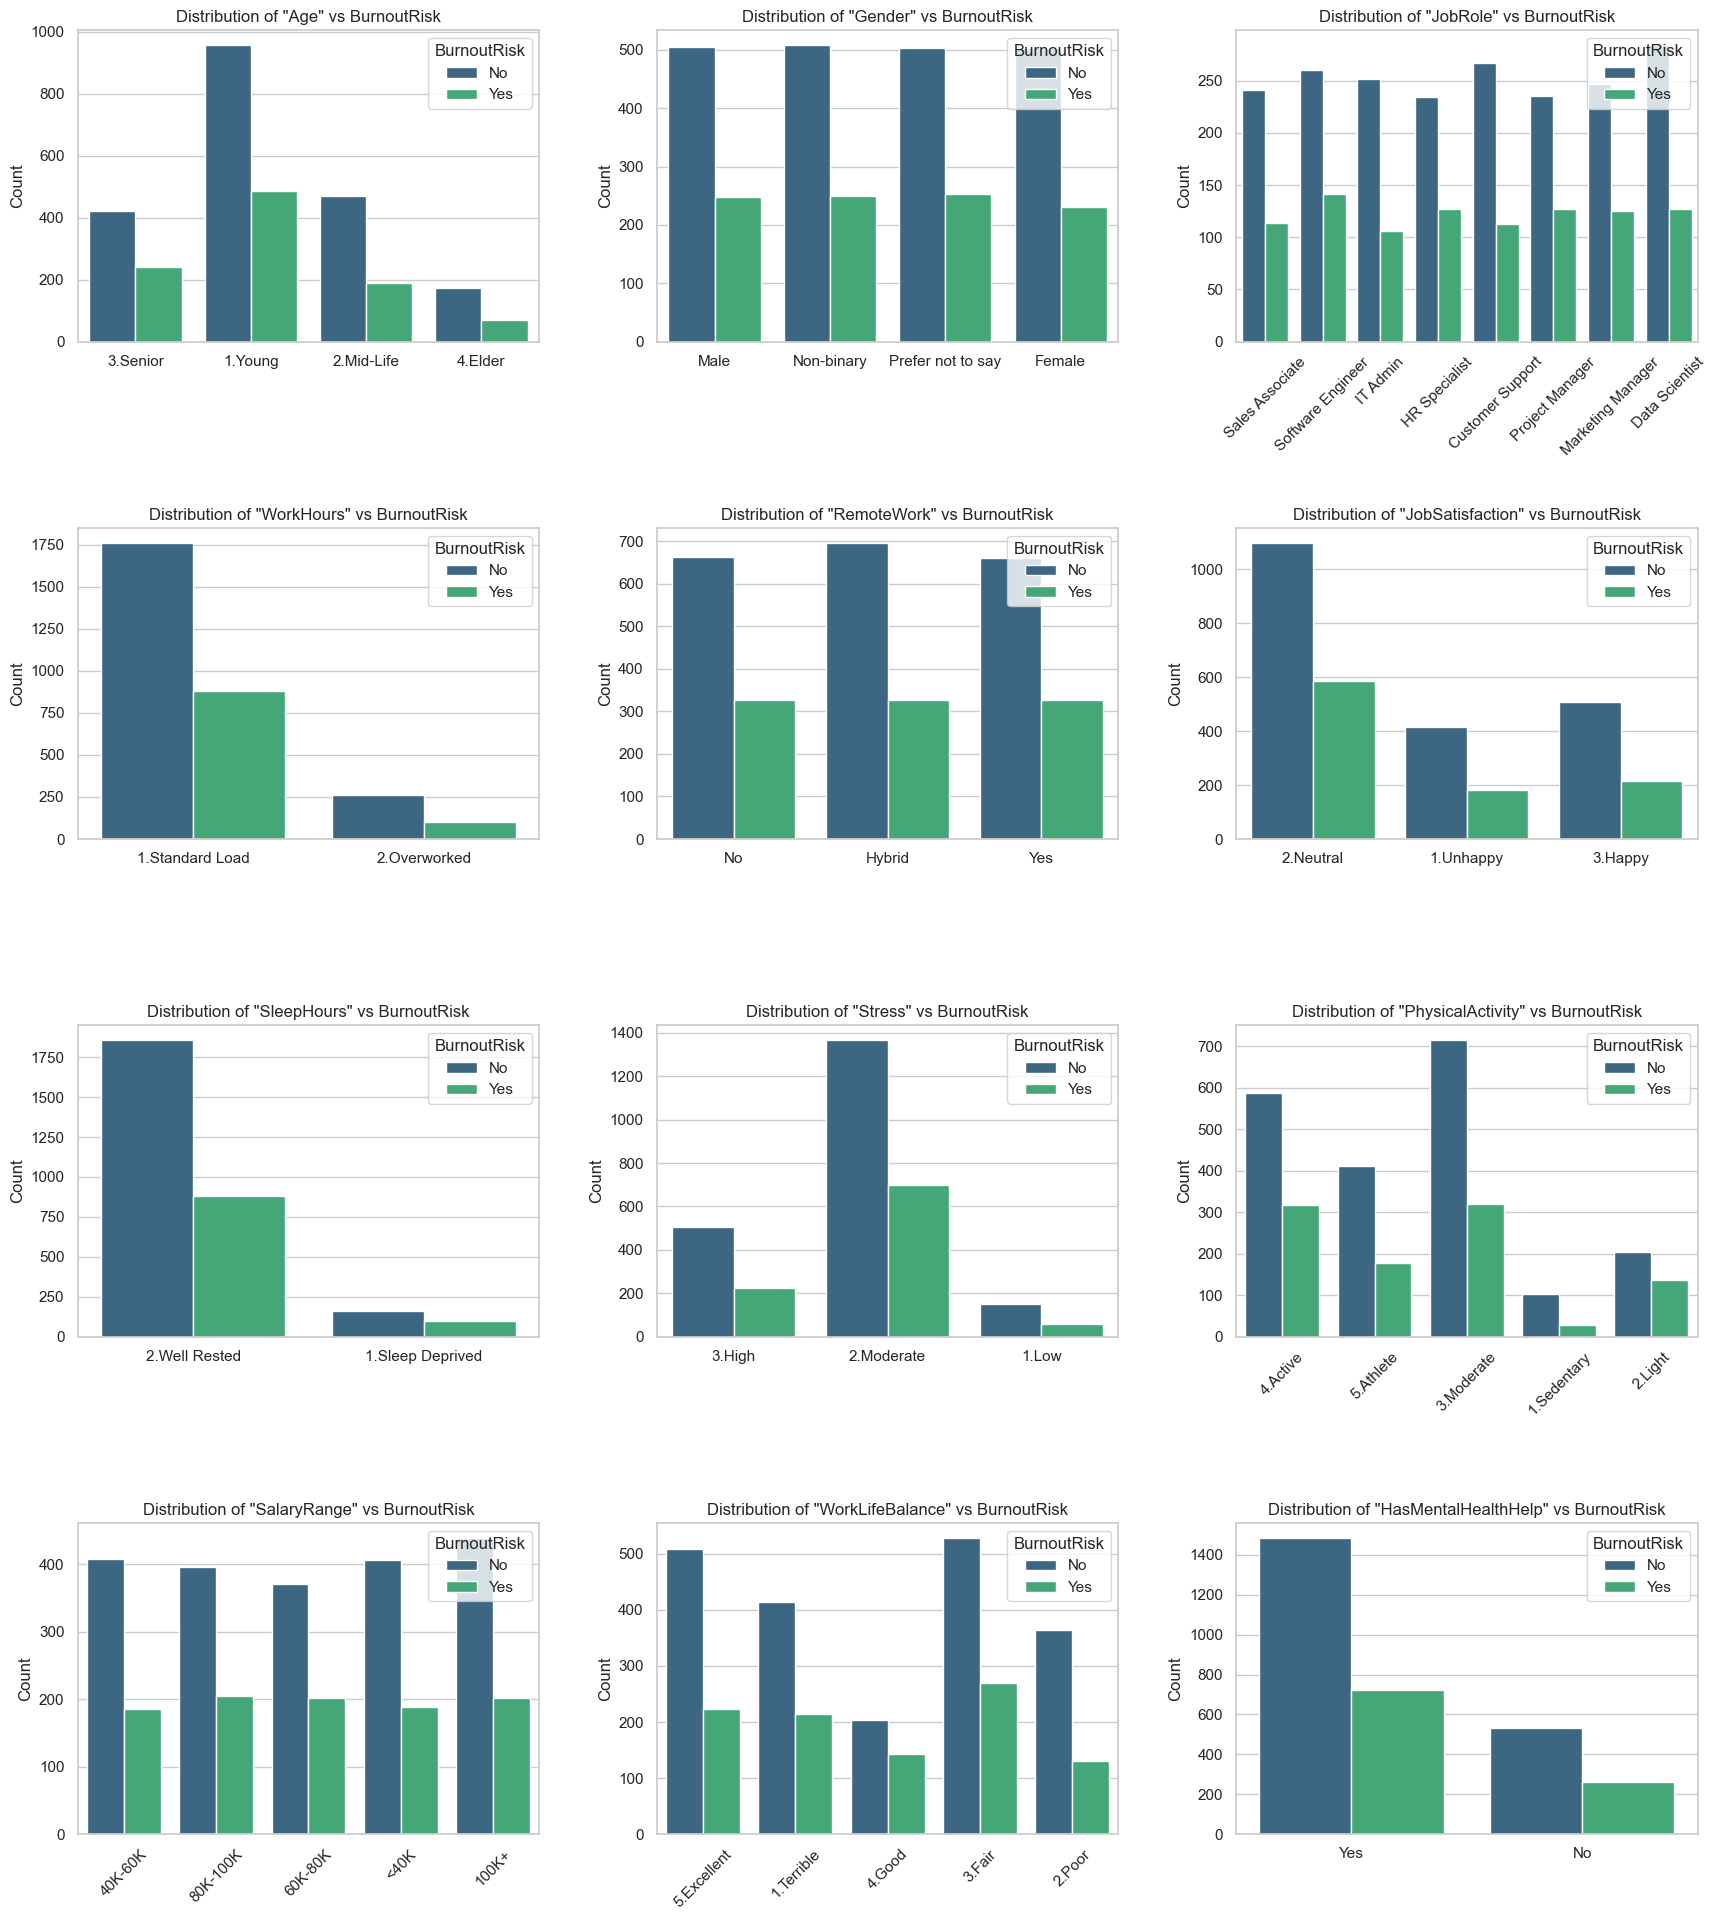

In [ ]:
# -----------------------------------------------------------------------------
# Visualization
# -----------------------------------------------------------------------------
sns.set_theme(style="whitegrid")

# Select the feature columns (excluding the target variable)
feature_columns = [col for col in df.columns if col != 'BurnoutRisk']

# Calculate the grid dimensions.
n_cols = 3
n_rows = (len(feature_columns) + n_cols - 1) // n_cols # FRounding

# print(f"About to create a grid of {n_rows}x{n_cols} plots...")

# -----------------------------------------------------------------------------
# Graphics grid creation
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 20))
axes = axes.flatten()

# One plot per feature
for i, col in enumerate(feature_columns):
    ax = axes[i]

    # Countplot with hue for BurnoutRisk
    sns.countplot(
        x=col,
        hue="BurnoutRisk",
        data=df,
        ax=ax,
        palette="viridis"
    )

    ax.set_title(f'Distribution of "{col}" vs BurnoutRisk', fontsize=12)

    if len(df[col].unique()) > 4:
         ax.tick_params(axis='x', rotation=45)

    ax.set_xlabel('')
    ax.set_ylabel('Count')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(pad=3.0)

plt.show()

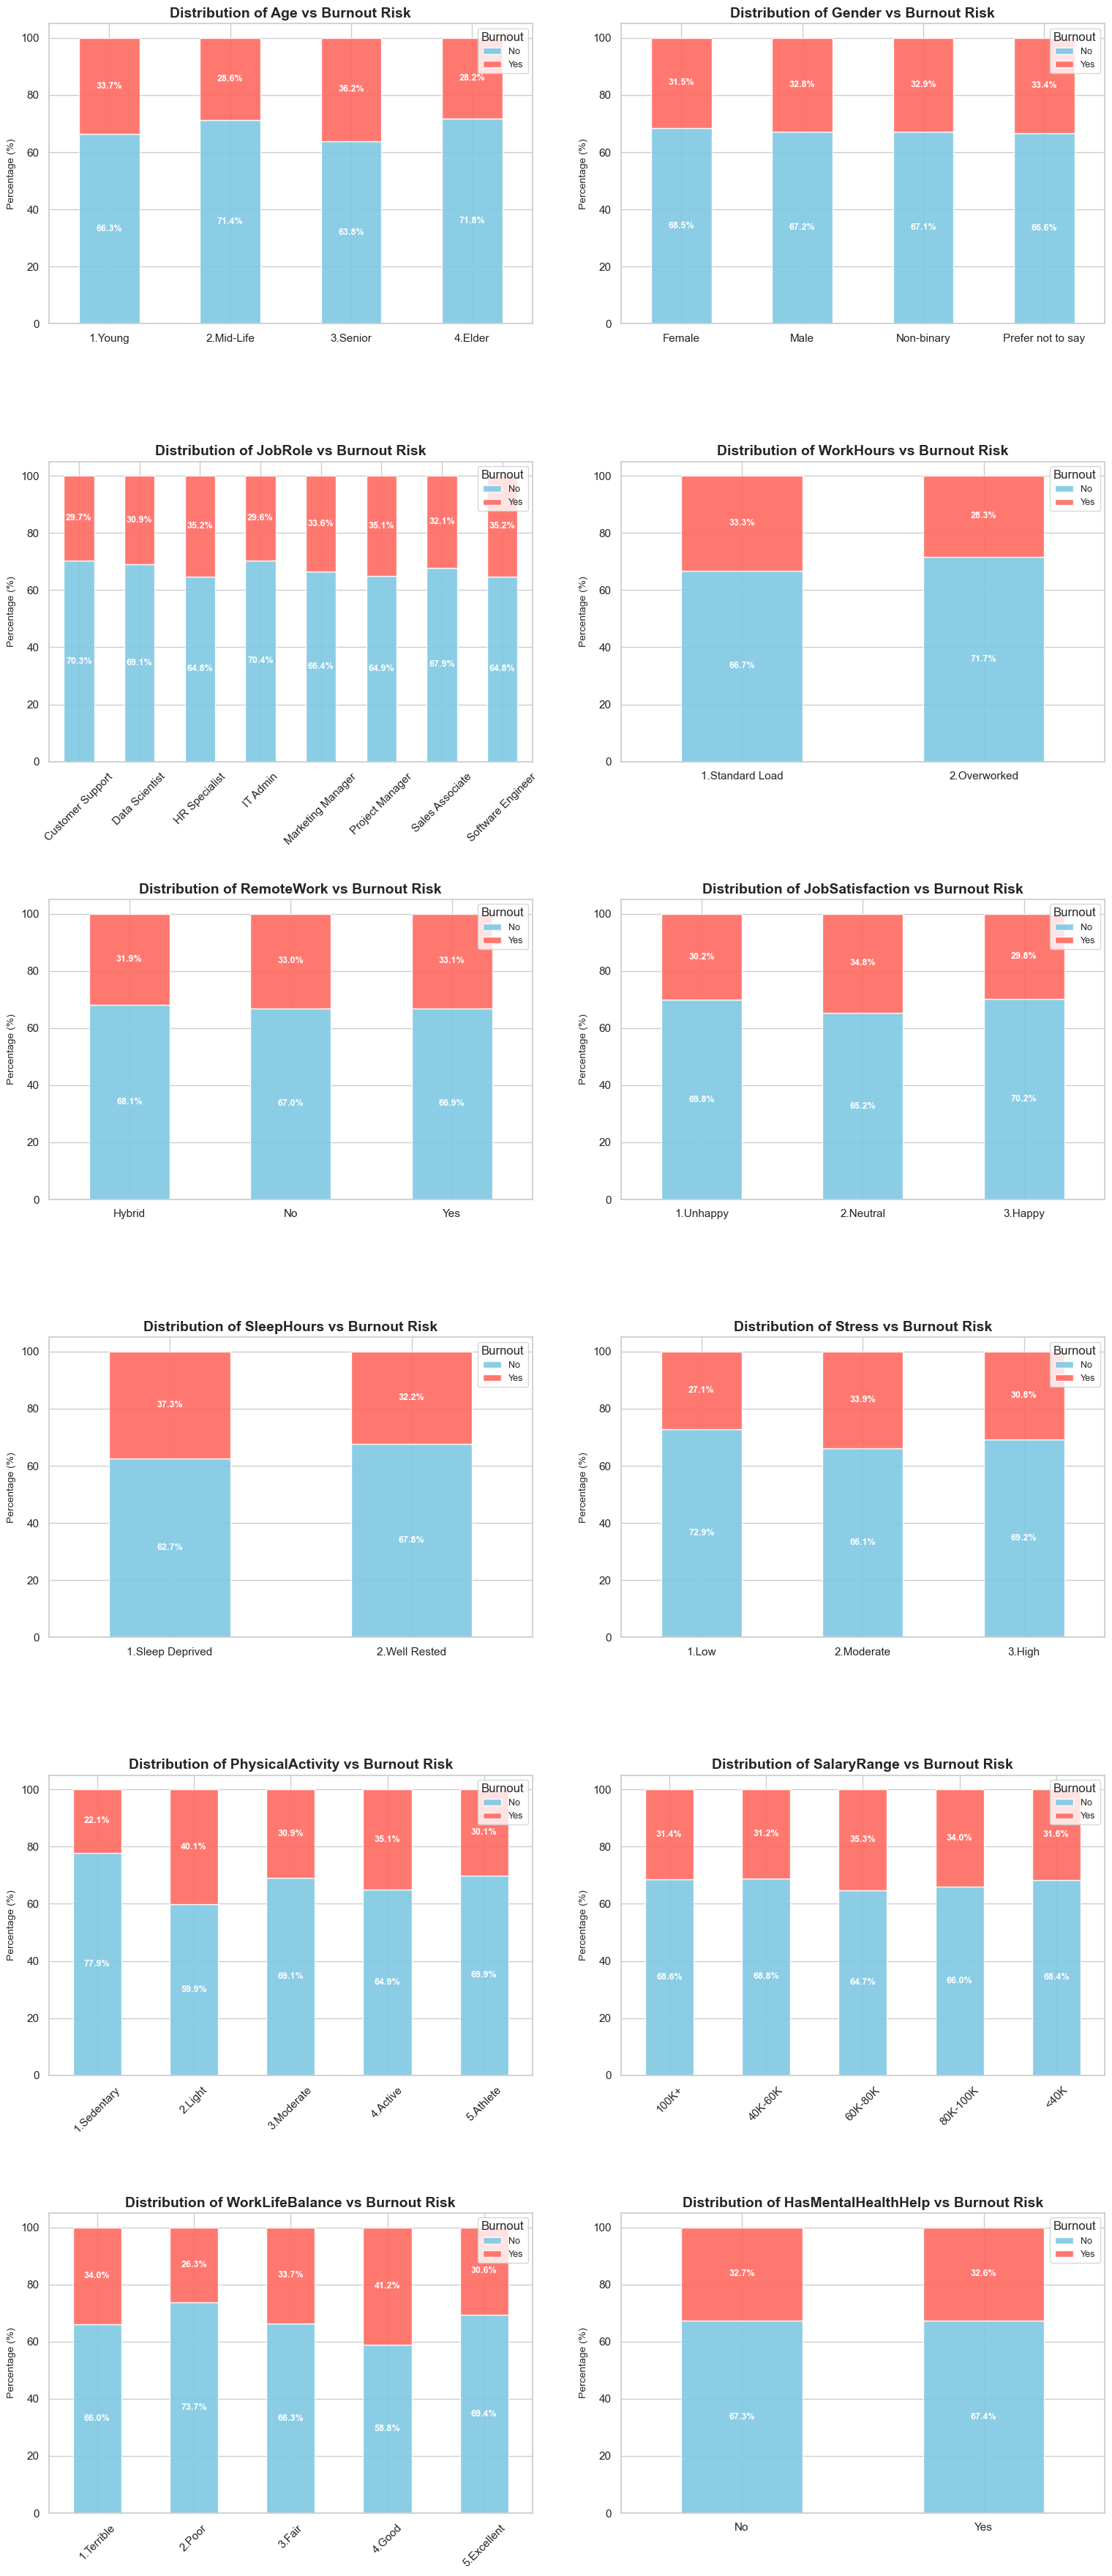

In [ ]:
target = 'BurnoutRisk'

# Re-define feature_columns as it was undefined in the previous execution
feature_columns = [col for col in df.columns if col != target]

# Calculate layout dynamically using all feature columns from the processed dataset
n_cols = 2
n_rows = (len(feature_columns) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
axes = axes.flatten() # Flatten for easy iteration

plt.style.use('seaborn-v0_8-pastel')

for i, col in enumerate(feature_columns):
    ax = axes[i]

    # Create Cross Tabulation (Proportions)
    ct = pd.crosstab(df[col], df[target], normalize='index') * 100

    # Plot Stacked Bar with a new color palette
    # Using a diverging colormap or custom colors for 'No' and 'Yes'
    ct.plot(kind='bar', stacked=True, ax=ax, color=['#7EC8E3', '#FF6961'], alpha=0.9) # Light Blue for No, Red for Yes

    # Formatting
    ax.set_title(f"Distribution of {col} vs Burnout Risk", fontsize=14, fontweight='bold')
    ax.set_ylabel("Percentage (%)", fontsize=10)
    ax.set_xlabel("")
    ax.legend(title='Burnout', labels=['No', 'Yes'], loc='upper right', fontsize=9)

    # Annotate bars with the % of each category
    for n, category in enumerate(ct.index.values):
        # Get percentages for 'No' and 'Yes'
        no_pct = ct.loc[category, 'No'] if 'No' in ct.columns else 0
        yes_pct = ct.loc[category, 'Yes'] if 'Yes' in ct.columns else 0

        # Annotate 'No' (bottom) segment if it's visible enough
        if no_pct > 5: # Only show if percentage is large enough
            ax.text(n, no_pct / 2, f"{no_pct:.1f}%",
                    ha='center', va='center', color='white', fontweight='bold', fontsize=9)

        # Annotate 'Yes' (top) segment if it's visible enough
        if yes_pct > 5: # Only show if percentage is large enough
            ax.text(n, no_pct + yes_pct / 2, f"{yes_pct:.1f}%",
                    ha='center', va='center', color='white', fontweight='bold', fontsize=9)

    # Rotate x-axis labels if there are many categories
    if len(df[col].unique()) > 4:
        ax.tick_params(axis='x', rotation=45)
    else:
        ax.tick_params(axis='x', rotation=0)

# Remove empty subplots if odd number of features
if len(feature_columns) < len(axes):
    for j in range(len(feature_columns), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)
plt.show()


## Network structure learning algorithms
Can take a while to run...


--- Method 1: Calculating Cramer's V Matrix ---
--- Method 2: Calculating Mutual Information Matrix ---
--- Method 3: Calculating Spearman's Rho (Ordinal) ---

--- Applying Causal Constraints (Zeroing out impossible edges) ---
Constraints applied: Relationships set to 0 where applicable.


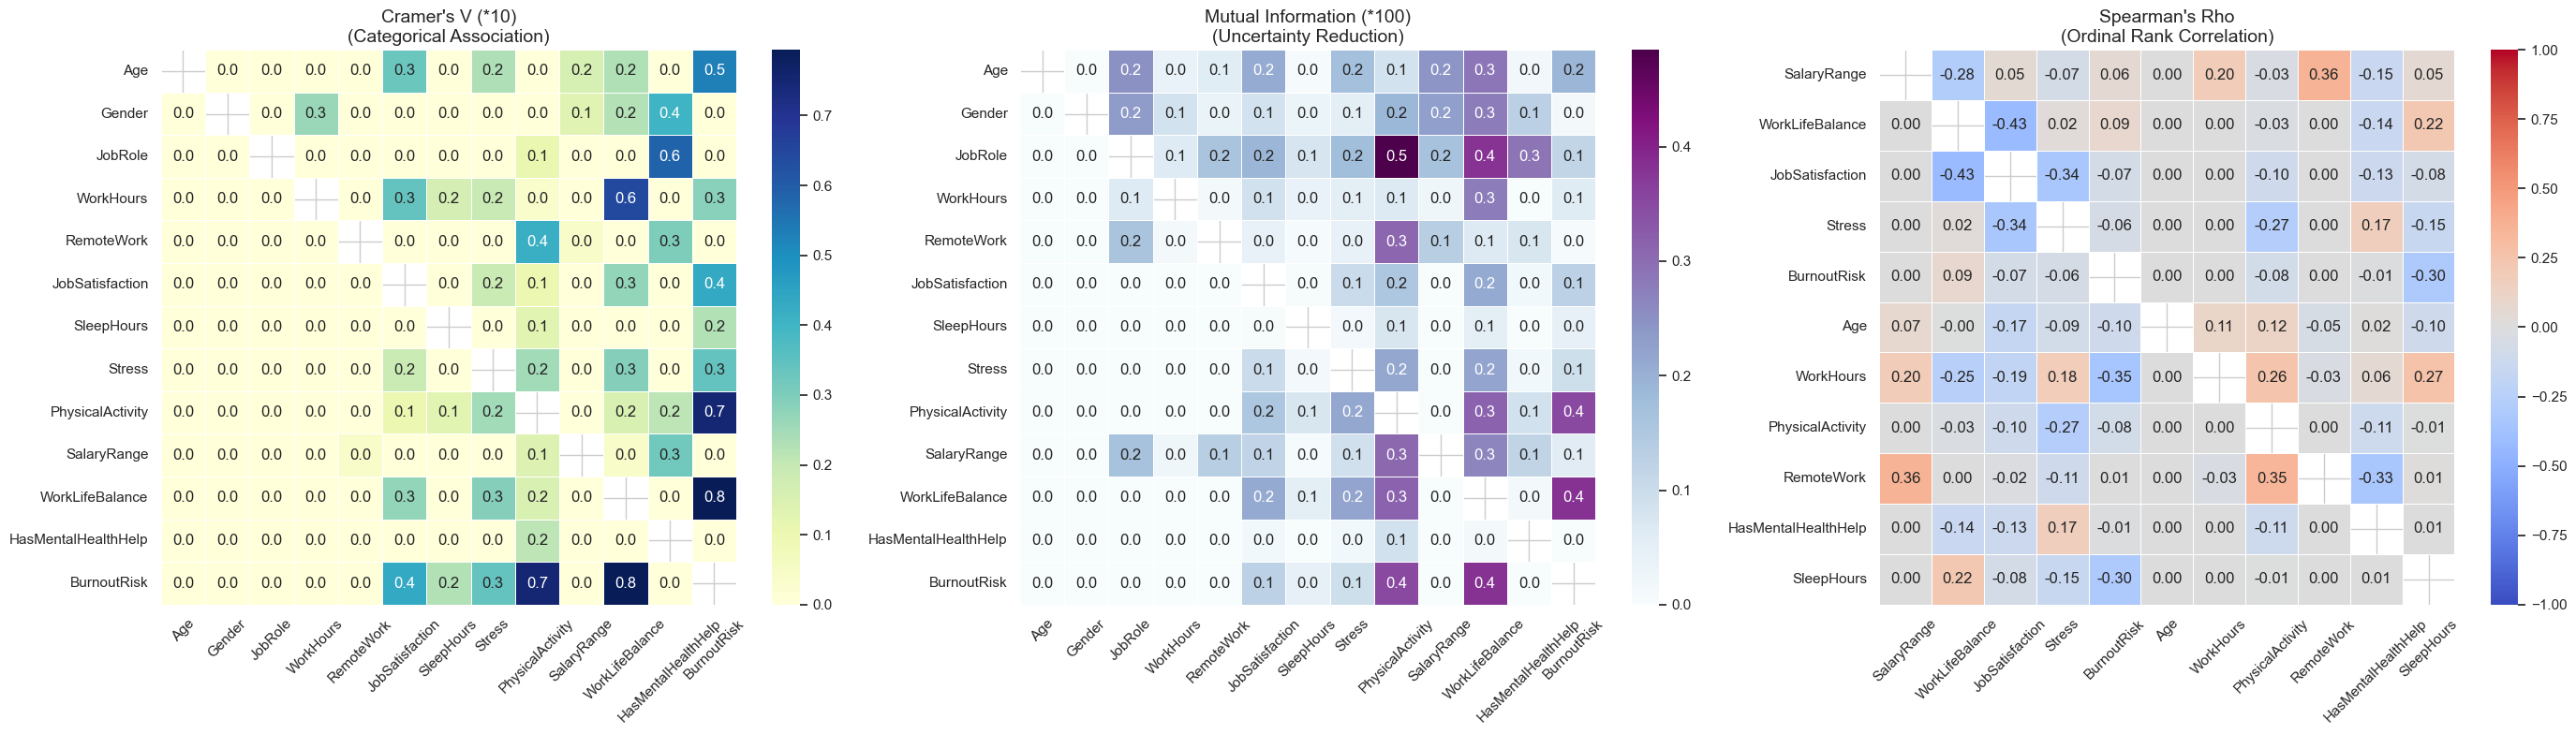


TOP 15 STRONGEST RELATIONSHIPS (All Metrics)

--- Top 15: Cramer's V (*10) ---
Metric           Source              Target    Score
Cramer      BurnoutRisk     WorkLifeBalance 0.794123
Cramer  WorkLifeBalance         BurnoutRisk 0.794123
Cramer      BurnoutRisk    PhysicalActivity 0.749960
Cramer PhysicalActivity         BurnoutRisk 0.749960
Cramer        WorkHours     WorkLifeBalance 0.642937
Cramer          JobRole HasMentalHealthHelp 0.585577
Cramer              Age         BurnoutRisk 0.528535
Cramer      BurnoutRisk     JobSatisfaction 0.434197
Cramer  JobSatisfaction         BurnoutRisk 0.434197
Cramer       RemoteWork    PhysicalActivity 0.417822
Cramer           Gender HasMentalHealthHelp 0.400365
Cramer        WorkHours     JobSatisfaction 0.341118
Cramer      BurnoutRisk              Stress 0.341108
Cramer           Stress         BurnoutRisk 0.341108
Cramer              Age     JobSatisfaction 0.329542

--- Top 15: Mutual Info (*100) ---
    Metric           Source         

In [ ]:
if 'df' in locals():
    cols = df.columns

    # -----------------------------
    # METHOD 1: CRAMER'S V
    # -----------------------------
    print("\n--- Method 1: Calculating Cramer's V Matrix ---")
    association_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)

    for i in range(len(cols)):
        for j in range(len(cols)):
            if i == j:
                association_matrix.iloc[i, j] = 1.0
            else:
                val = cramers_v(df[cols[i]].astype(str), df[cols[j]].astype(str))
                association_matrix.iloc[i, j] = val

    # -----------------------------
    # METHOD 2: MUTUAL INFORMATION
    # -----------------------------
    print("--- Method 2: Calculating Mutual Information Matrix ---")
    mi_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)
    df_encoded = df.copy()
    le = LabelEncoder()
    for col in cols:
        df_encoded[col] = le.fit_transform(df[col].astype(str))

    for i in range(len(cols)):
        for j in range(len(cols)):
             val = mutual_info_score(df_encoded[cols[i]], df_encoded[cols[j]])
             mi_matrix.iloc[i, j] = val

    # -----------------------------
    # METHOD 3: SPEARMAN'S RHO (For Ordinal Data)
    # -----------------------------
    print("--- Method 3: Calculating Spearman's Rho (Ordinal) ---")

    # Define Ordinal Columns (Sub-selection of data that has order)
    ordinal_cols = ['SalaryRange', 'WorkLifeBalance', 'JobSatisfaction',
                    'Stress', 'BurnoutRisk', 'Age', 'WorkHours', 'PhysicalActivity', 'RemoteWork', 'HasMentalHealthHelp', 'SleepHours']

    # Intersect with actual columns to avoid errors
    ordinal_cols = [c for c in ordinal_cols if c in df.columns]

    custom_mappings = {
        '1.Young': 1, '2.Mid-Life': 2, '3.Senior': 3, '4.Elder': 4,
        '1.Standard Load': 1, '2.Overworked': 2,
        '1.Unhappy': 1, '2.Neutral': 2, '3.Happy': 3,
        '1.Low': 1, '2.Moderate': 2, '3.High': 3,
        '1.Sleep Deprived': 1, '2.Well Rested': 2,
        '1.Sedentary': 1, '2.Light': 2, '3.Moderate': 3, '4.Active': 4, '5.Athlete': 5,
        '1.Terrible': 1, '2.Poor': 2, '3.Fair': 3, '4.Good': 4, '5.Excellent': 5,
        'No': 0, 'Yes': 1, 'Hybrid':0.5,
        '<40K': 0, '40K-60K':1, '60K-80K':2, '80K-100K':3, '100K+':4,
        'No': 0, 'Yes': 1,
    }

    df_ordinal = df.copy()

    # Attempt to map values
    for col in ordinal_cols:
        if not pd.api.types.is_numeric_dtype(df_ordinal[col]):
            mapped_series = df_ordinal[col].map(custom_mappings)

            # If mapping left NaNs (because strings didn't match), fall back to Label Encoding
            if mapped_series.isna().sum() > 0:
                # print(f"  Note: Automatic mapping failed for some values in '{col}'. Using alphabetical rank.")
                le = LabelEncoder()
                df_ordinal[col] = le.fit_transform(df_ordinal[col].astype(str))
            else:
                df_ordinal[col] = mapped_series

    # Calculate Spearman Matrix only for ordinal columns
    spearman_matrix = df_ordinal[ordinal_cols].corr(method='spearman')

    # Fill NaN (in case of constant columns) with 0
    spearman_matrix = spearman_matrix.fillna(0)

    # ==========================================
    # APPLY COMMON SENSE CONSTRAINTS
    # ==========================================
    print("\n--- Applying Causal Constraints (Zeroing out impossible edges) ---")

    tier_1_demographics = ['Age', 'Gender']
    tier_2_job_context  = ['JobRole', 'WorkHours', 'RemoteWork', 'SalaryRange']
    tier_3_mental_states = ['Stress', 'BurnoutRisk', 'JobSatisfaction', 'WorkLifeBalance',
                            'HasMentalHealthHelp', 'PhysicalActivity', 'SleepHours']

    forbidden_edges = []

    # Rule A: NOTHING causes Demographics
    for target in tier_1_demographics:
        for source in df.columns:
            if source != target:
                forbidden_edges.append((source, target))

    # Rule B: Mental States cannot cause Job Context
    for source in tier_3_mental_states:
        for target in tier_2_job_context:
            forbidden_edges.append((source, target))

    # Apply zeros to all matrices
    count_masked = 0
    for source, target in forbidden_edges:
        # Cramer's V
        if source in association_matrix.index and target in association_matrix.columns:
            association_matrix.loc[source, target] = 0.0
            count_masked += 1
        # Mutual Info
        if source in mi_matrix.index and target in mi_matrix.columns:
            mi_matrix.loc[source, target] = 0.0
        # Spearman (Only if both exist in the ordinal set)
        if source in spearman_matrix.index and target in spearman_matrix.columns:
            spearman_matrix.loc[source, target] = 0.0

    print(f"Constraints applied: Relationships set to 0 where applicable.")

    # ==========================================
    # VISUALIZATION: 3-PANEL PLOT
    # ==========================================
    fig, axes = plt.subplots(1, 3, figsize=(28, 8))

    # --- PLOT 1: Cramer's V ---
    mask_cv = np.eye(len(association_matrix), dtype=bool)
    sns.heatmap(association_matrix * 10, annot=True, cmap='YlGnBu', fmt=".1f",
                linewidths=.5, mask=mask_cv, ax=axes[0])
    axes[0].set_title("Cramer's V (*10)\n(Categorical Association)", fontsize=14)
    axes[0].tick_params(axis='x', rotation=45)

    # --- PLOT 2: Mutual Information ---
    mask_mi = np.eye(len(mi_matrix), dtype=bool)
    sns.heatmap(mi_matrix * 100, annot=True, cmap='BuPu', fmt=".1f",
                linewidths=.5, mask=mask_mi, ax=axes[1])
    axes[1].set_title("Mutual Information (*100)\n(Uncertainty Reduction)", fontsize=14)
    axes[1].tick_params(axis='x', rotation=45)

    # --- PLOT 3: Spearman's Rho ---
    mask_sp = np.eye(len(spearman_matrix), dtype=bool)
    sns.heatmap(spearman_matrix * 10, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1,
                linewidths=.5, mask=mask_sp, ax=axes[2])
    axes[2].set_title("Spearman's Rho\n(Ordinal Rank Correlation)", fontsize=14)
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # ==========================================
    # GLOBAL RANKING: TOP 15 PAIRS
    # ==========================================
    def get_top_pairs(matrix, metric_name, scale=1, use_abs=False):
        pairs = []
        columns = matrix.columns
        for i in range(len(columns)):
            for j in range(len(columns)):
                if i == j: continue
                val = matrix.iloc[i, j]
                # Filter zeros (constrained)
                if val == 0: continue

                score = abs(val) if use_abs else val

                pairs.append({
                    'Metric': metric_name,
                    'Source': columns[i],
                    'Target': columns[j],
                    'Score': val * scale
                })

        # Sort by absolute score descending
        df_pairs = pd.DataFrame(pairs)
        if not df_pairs.empty:
            df_pairs['AbsScore'] = df_pairs['Score'].abs()
            df_pairs = df_pairs.sort_values(by='AbsScore', ascending=False).drop(columns=['AbsScore'])
            return df_pairs.head(15)
        return pd.DataFrame()

    print("\n" + "="*60)
    print("TOP 15 STRONGEST RELATIONSHIPS (All Metrics)")
    print("="*60)

    print("\n--- Top 15: Cramer's V (*10) ---")
    print(get_top_pairs(association_matrix, "Cramer", scale=10).to_string(index=False))

    print("\n--- Top 15: Mutual Info (*100) ---")
    print(get_top_pairs(mi_matrix, "MutualInfo", scale=100).to_string(index=False))

    print("\n--- Top 15: Spearman's Rho (Ordinal Only) ---")
    print(get_top_pairs(spearman_matrix, "Spearman", scale=10, use_abs=True).to_string(index=False))

In [20]:
# 1. Define "Common Sense" Constraints (The Black List)
# ---------------------------------------------------------
tier_1_demographics = ['Age', 'Gender']
tier_2_job_context  = ['JobRole', 'WorkHours', 'RemoteWork', 'SalaryRange']
tier_3_mental_states = ['Stress', 'BurnoutRisk', 'JobSatisfaction', 'WorkLifeBalance',
                        'HasMentalHealthHelp', 'PhysicalActivity', 'SleepHours']

forbidden_edges = []

# Rule A: NOTHING causes Demographics
for target in tier_1_demographics:
    for source in df.columns:
        if source != target:
            forbidden_edges.append((source, target))

# Rule B: Mental States cannot cause Job Context
for source in tier_3_mental_states:
    for target in tier_2_job_context:
        forbidden_edges.append((source, target))

expert = ExpertKnowledge(forbidden_edges=forbidden_edges)

print(f"Constraints generated: {len(forbidden_edges)} forbidden edges.")

Constraints generated: 52 forbidden edges.


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Age': 'C', 'Gender': 'C', 'JobRole': 'C', 'WorkHours': 'C', 'RemoteWork': 'C', 'JobSatisfaction': 'C', 'SleepHours': 'C', 'Stress': 'C', 'PhysicalActivity': 'C', 'SalaryRange': 'C', 'WorkLifeBalance': 'C', 'HasMentalHealthHelp': 'C', 'BurnoutRisk': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Age': 'C', 'Gender': 'C', 'JobRole': 'C', 'WorkHours': 'C', 'RemoteWork': 'C', 'JobSatisfaction': 'C', 'SleepHours': 'C', 'Stress': 'C', 'PhysicalActivity': 'C', 'SalaryRange': 'C', 'WorkLifeBalance': 'C', 'HasMentalHealthHelp': 'C', 'BurnoutRisk': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Age': 'C', 'Gender': 'C', 'JobRole': 'C', 'WorkHours': 'C', 'RemoteWork': 'C', 'JobSatisfaction': 'C', 'SleepHours': 'C', 'Stress': 'C', 'PhysicalActivity': 'C', 'SalaryRa

------------------------------------------------------------
Starting Structure Learning Comparison...
------------------------------------------------------------

[1] Hill Climb Search
  > Running HillClimb with AIC...


Plotting: Hill Climb - AIC (Edges: 10)


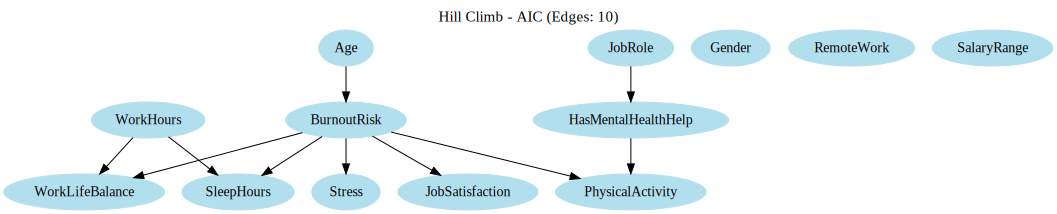

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Age': 'C', 'Gender': 'C', 'JobRole': 'C', 'WorkHours': 'C', 'RemoteWork': 'C', 'JobSatisfaction': 'C', 'SleepHours': 'C', 'Stress': 'C', 'PhysicalActivity': 'C', 'SalaryRange': 'C', 'WorkLifeBalance': 'C', 'HasMentalHealthHelp': 'C', 'BurnoutRisk': 'C'}



[2] PC Algorithm
  > Running PC with chi_square...
Plotting: PC Algorithm - chi_square (Edges: 4)


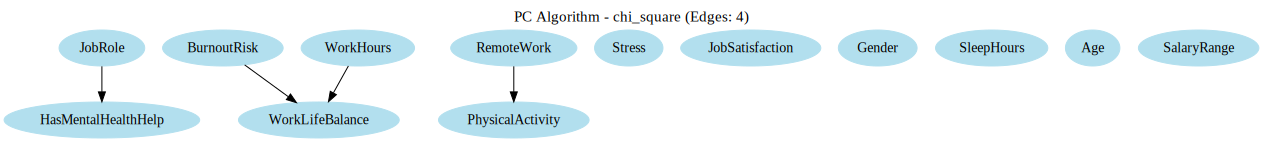

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Age': 'C', 'Gender': 'C', 'JobRole': 'C', 'WorkHours': 'C', 'RemoteWork': 'C', 'JobSatisfaction': 'C', 'SleepHours': 'C', 'Stress': 'C', 'PhysicalActivity': 'C', 'SalaryRange': 'C', 'WorkLifeBalance': 'C', 'HasMentalHealthHelp': 'C', 'BurnoutRisk': 'C'}



[3] Tree Search
  > Running Chow-Liu (Tree)...


Building tree:   0%|          | 0/78.0 [00:00<?, ?it/s]

Plotting: Tree Search - Chow-Liu (Edges: 12)


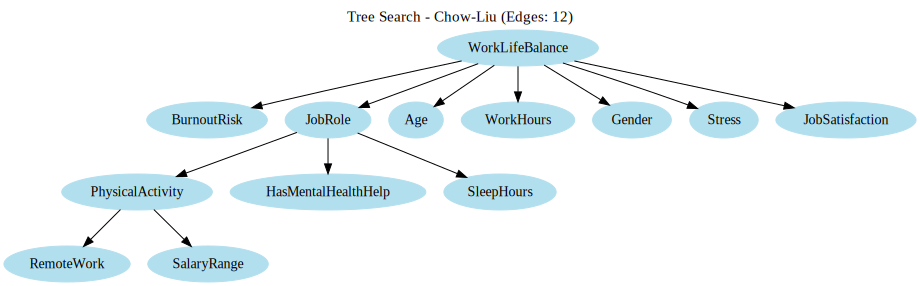

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Age': 'C', 'Gender': 'C', 'JobRole': 'C', 'WorkHours': 'C', 'RemoteWork': 'C', 'JobSatisfaction': 'C', 'SleepHours': 'C', 'Stress': 'C', 'PhysicalActivity': 'C', 'SalaryRange': 'C', 'WorkLifeBalance': 'C', 'HasMentalHealthHelp': 'C', 'BurnoutRisk': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Age': 'C', 'Gender': 'C', 'JobRole': 'C', 'WorkHours': 'C', 'RemoteWork': 'C', 'JobSatisfaction': 'C', 'SleepHours': 'C', 'Stress': 'C', 'PhysicalActivity': 'C', 'SalaryRange': 'C', 'WorkLifeBalance': 'C', 'HasMentalHealthHelp': 'C', 'BurnoutRisk': 'C'}



[4] MMHC Algorithm (Hybrid) - Optimized
  > Running MMHC with AIC (Least Strict Parameters)...
    > Step 1: Learning Skeleton (PC phase)...


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Age': 'C', 'Gender': 'C', 'JobRole': 'C', 'WorkHours': 'C', 'RemoteWork': 'C', 'JobSatisfaction': 'C', 'SleepHours': 'C', 'Stress': 'C', 'PhysicalActivity': 'C', 'SalaryRange': 'C', 'WorkLifeBalance': 'C', 'HasMentalHealthHelp': 'C', 'BurnoutRisk': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Age': 'C', 'Gender': 'C', 'JobRole': 'C', 'WorkHours': 'C', 'RemoteWork': 'C', 'JobSatisfaction': 'C', 'SleepHours': 'C', 'Stress': 'C', 'PhysicalActivity': 'C', 'SalaryRange': 'C', 'WorkLifeBalance': 'C', 'HasMentalHealthHelp': 'C', 'BurnoutRisk': 'C'}


    > Step 2: Orientation (HillClimb) restricted to skeleton (4 edges)...
Plotting: MMHC - AIC (Loose) (Edges: 4)


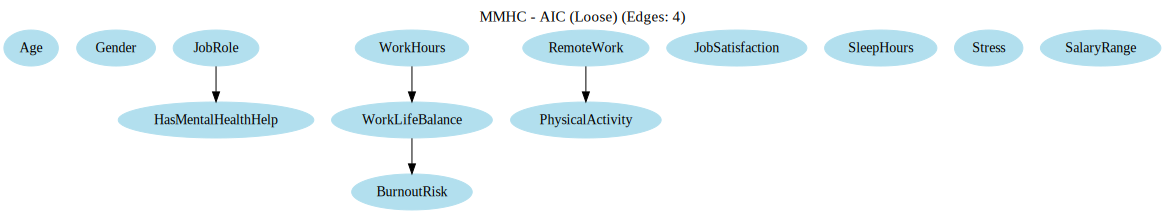


Comparison Complete.


In [ ]:
print("-" * 60)
print("Starting Structure Learning Comparison...")
print("-" * 60)

# ==========================================
# 1. Hill Climb Search (Score-Based)
# ==========================================
print("\n[1] Hill Climb Search")
hc = HillClimbSearch(df)

# List of scoring classes to try
scoring_classes = [AIC]

for ScoreClass in scoring_classes:
    metric_name = ScoreClass.__name__
    try:
        print(f"  > Running HillClimb with {metric_name}...")
        scorer = ScoreClass(df)
        model = hc.estimate(scoring_method=scorer, expert_knowledge=expert, tabu_length=100, epsilon=1e-8, show_progress=False)
        visualize_structure(model, f"Hill Climb - {metric_name}")
    except Exception as e:
        print(f"    Failed: {e}")

# ==========================================
# 2. PC Algorithm (Constraint-Based)
# ==========================================
print("\n[2] PC Algorithm")
pc = PC(df)
independence_tests = ['chi_square']

for test in independence_tests:
    try:
        print(f"  > Running PC with {test}...")
        # significance_level 0.05 is standard. Lower (0.01) is stricter.
        model = pc.estimate(variant='stable', ci_test=test, return_type='pdag', expert_knowledge=expert, significance_level=0.05, show_progress=False)
        visualize_structure(model, f"PC Algorithm - {test}")
    except Exception as e:
        print(f"    Failed: {e}")

# ==========================================
# 3. Tree Search (Chow-Liu)
# ==========================================
print("\n[3] Tree Search")
ts = TreeSearch(df)

try:
    print("  > Running Chow-Liu (Tree)...")
    model = ts.estimate(estimator_type='chow-liu')
    visualize_structure(model, "Tree Search - Chow-Liu")
except Exception as e:
    print(f"    Failed: {e}")

# ==========================================
# 4. MMHC Algorithm (Hybrid) - Optimized
# ==========================================
print("\n[4] MMHC Algorithm (Hybrid) - Optimized")

# Use AIC as the primary scorer (Least Strict)
current_scoring_classes = [AIC]

for ScoreClass in current_scoring_classes:
    metric_name = ScoreClass.__name__
    try:
        print(f"  > Running MMHC with {metric_name} (Least Strict Parameters)...")
        scorer = ScoreClass(df)

        # --- MANUAL MMHC IMPLEMENTATION ---
        # 1. Find the Skeleton (Using PC)
        print("    > Step 1: Learning Skeleton (PC phase)...")
        pc_skel = PC(df)
        skeleton_pdag = pc_skel.estimate(
            variant='stable',
            significance_level=0.05, # Increased for looseness
            max_cond_vars=1,         # Decreased for looseness
            return_type='pdag',
            show_progress=False
        )
        skeleton = skeleton_pdag.to_undirected()

        # 2. Prepare Constraints from Skeleton
        all_nodes = df.columns.tolist()
        skeleton_edges_set = set()
        for u, v in skeleton.edges():
            skeleton_edges_set.add(frozenset([u, v]))

        skeleton_forbidden = []
        for u in all_nodes:
            for v in all_nodes:
                if u == v: continue
                # If connection {u, v} NOT in skeleton, forbid u->v
                if frozenset([u, v]) not in skeleton_edges_set:
                    skeleton_forbidden.append((u, v))

        # Combine with original expert constraints
        final_forbidden = list(set(forbidden_edges + skeleton_forbidden))
        mmhc_expert = ExpertKnowledge(forbidden_edges=final_forbidden)

        # 3. Orient Edges (Hill Climb)
        print(f"    > Step 2: Orientation (HillClimb) restricted to skeleton ({len(skeleton.edges())} edges)...")
        hc_step = HillClimbSearch(df)

        # Added 'tabu_length' and very low 'epsilon' for strictness control
        model = hc_step.estimate(
            scoring_method=scorer,
            expert_knowledge=mmhc_expert,
            tabu_length=10000,
            epsilon=1e-10,
            show_progress=False
        )

        visualize_structure(model, f"MMHC - {metric_name} (Loose)")

    except Exception as e:
        print(f"    Failed: {e}")
        import traceback
        traceback.print_exc()

print("\nComparison Complete.")

## Making the DBN

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Age': 'C', 'Gender': 'C', 'JobRole': 'C', 'WorkHours': 'C', 'RemoteWork': 'C', 'JobSatisfaction': 'C', 'SleepHours': 'C', 'Stress': 'C', 'PhysicalActivity': 'C', 'SalaryRange': 'C', 'WorkLifeBalance': 'C', 'HasMentalHealthHelp': 'C', 'BurnoutRisk': 'C'}



Network structure after modifications.


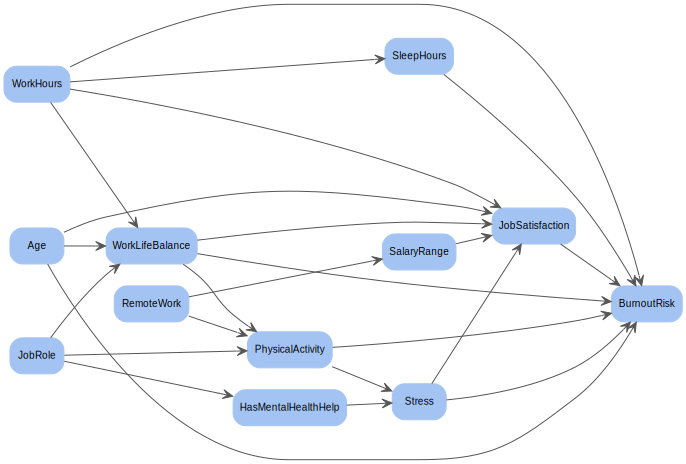


  The modified network has been displayed below.


In [22]:
# Definition of the Bayesian Network structure

model_structure = [

    #MMHC Algorithm + Chi square
    ('JobRole', 'HasMentalHealthHelp'),
    ('WorkHours', 'WorkLifeBalance'),
    ('WorkLifeBalance', 'BurnoutRisk'),
    ('RemoteWork', 'PhysicalActivity'),

    #Cramers V assosiation
    ('PhysicalActivity', 'BurnoutRisk'),
    ('Age', 'BurnoutRisk'),
    ('JobSatisfaction', 'BurnoutRisk'),
    ('WorkHours', 'JobSatisfaction'),
    ('Stress', 'BurnoutRisk'),
    ('Age', 'JobSatisfaction'),

    #Mutual information
    ('JobRole', 'PhysicalActivity'),
    ('JobRole', 'WorkLifeBalance'),
    ('WorkLifeBalance', 'PhysicalActivity'), #or the other side maybe
    ('Age', 'WorkLifeBalance'),

    #Spearman
    ('WorkLifeBalance', 'JobSatisfaction'),
    ('RemoteWork', 'SalaryRange'),
    ('WorkHours', 'BurnoutRisk'),
    ('Stress', 'JobSatisfaction'),
    ('SleepHours', 'BurnoutRisk'),
    ('PhysicalActivity', 'Stress'),

    #intuition
    ('SalaryRange', 'JobSatisfaction'),
    ('HasMentalHealthHelp', 'Stress'),
    ('WorkHours', 'SleepHours'),

]

# Model creation
model = DiscreteBayesianNetwork(model_structure)

print("\nNetwork structure after modifications.")

if nx.is_weakly_connected(model):
    pass
else:
    print("WARNING: The network is disconnected!")


# MODEL TRAINING
model.fit(
    data=df,
    estimator=BayesianEstimator,
    prior_type="BDeu",
    equivalent_sample_size=10
)

model.check_model()

try:
    dot = graphviz.Digraph(comment='Bayesian Network of Burnout Risk - Modified')
    dot.attr(rankdir='LR', splines='spline', overlap='false', nodesep='0.3', ranksep='0.5')
    dot.attr('node', shape='box', style='rounded,filled', color='#a3c4f3', fontname='Helvetica', fontsize='10')
    dot.attr('edge', color='#555555', arrowhead='vee', penwidth='1.0', fontname='Helvetica', fontsize='8')

    # Add nodes and edges to the visualization
    for node in model.nodes():
        dot.node(node, node)
    for edge in model.edges():
        dot.edge(edge[0], edge[1])

    # Display the graph directly in the notebook
    display(dot)

    print(f"\n  The modified network has been displayed below.")

except graphviz.backend.execute.ExecutableNotFound:
    print("\n VISUALIZATION ERROR: Graphviz executable not found.")
    print("Make sure Graphviz is installed and its 'bin' is in the system PATH.")
except Exception as e:
    print(f"\n An error occurred during visualization: {e}")

# Analysis and Investigating model

## Causal Inference

In [23]:
if 'model' not in locals() or 'df' not in locals():
    print("Error: 'model' and 'df' must be loaded in the workspace.")
else:
    infer = VariableElimination(model)

    # --- HELPER FUNCTIONS ---
    def get_prob(result, var, state):
        try:
            return result.values[result.state_names[var].index(state)]
        except:
            return 0.0

    def causal_inference(target_var, intervention_var, intervention_val):
        """Simulates do(intervention_var = intervention_val) for a single variable."""
        return causal_inference_multi(target_var, {intervention_var: intervention_val})

    def causal_inference_multi(target_var, interventions):
        """
        Simulates do(var1=val1, var2=val2, ...) for multiple variables simultaneously.
        interventions: dict mapping {variable_name: state_name}
        """
        model_int = model.copy()

        for var, val in interventions.items():
            # 1. Cut back-door paths (remove parents)
            parents = model_int.get_parents(var)
            for parent in parents:
                model_int.remove_edge(parent, var)

            # 2. Force state probabilities
            try:
                states = model.get_cpds(var).state_names[var]
                probs = np.zeros(len(states))
                try:
                    idx = states.index(val)
                except:
                    idx = [str(s) for s in states].index(str(val))
                probs[idx] = 1.0

                new_cpd = TabularCPD(variable=var, variable_card=len(states),
                                     values=probs.reshape(-1, 1), state_names={var: states})
                old_cpd = model_int.get_cpds(var)
                model_int.remove_cpds(old_cpd)
                model_int.add_cpds(new_cpd)
            except Exception as e:
                print(f"Error forcing {var}={val}: {e}")
                return None

        try:
            return VariableElimination(model_int).query([target_var], show_progress=False)
        except Exception as e:
            print(f"Inference Error: {e}")
            return None

    # --- USER PROVIDED LOGIC ---
    burnout_label = 'Yes'

    print("\n CAUSAL INFERENCE (The 'God Mode' Interventions)")
    print("=" * 80)

    # 1. Golden Handcuffs
    # ------------------------------------------------
    try:
        high_salary = '100K+'
        print(f"\n--- SCENARIO 1: The 'Golden Handcuffs' Paradox ---\nTHE LOGIC: Does money actually cure burnout, or do rich people just have harder jobs?\n   1. Observational: We look at people who *earned* a '{high_salary}' salary naturally.\n   2. Causal: We simulate *giving* a '{high_salary}' salary to a random person (Intervention).")

        obs_res = infer.query(['BurnoutRisk'], evidence={'SalaryRange': high_salary}, show_progress=False)
        causal_res = causal_inference('BurnoutRisk', 'SalaryRange', high_salary)

        r_obs = get_prob(obs_res, 'BurnoutRisk', burnout_label)
        r_causal = get_prob(causal_res, 'BurnoutRisk', burnout_label)

        print(f"RESULT:\n   - Observational Risk: {r_obs:.1%} (Includes stress of the job)\n   - Causal Risk:        {r_causal:.1%} (Pure effect of money)")
    except Exception as e: print(f"Skipped: {e}")

    # 2. Forced Vacation Policy
    # ------------------------------------------------
    try:
        std_hours = '1.Standard Load'
        print(f"\n--- SCENARIO 2: The 'Forced Vacation' Policy ---\nTHE LOGIC: If we mandate that NO ONE is allowed to work overtime, what happens?\n   We force 'WorkHours' to '{std_hours}' for the entire population and compare to current baseline.")

        base_res = infer.query(['BurnoutRisk'], show_progress=False)
        policy_res = causal_inference('BurnoutRisk', 'WorkHours', std_hours)

        r_base = get_prob(base_res, 'BurnoutRisk', burnout_label)
        r_policy = get_prob(policy_res, 'BurnoutRisk', burnout_label)

        print(f"RESULT:\n   - Current Baseline Risk: {r_base:.1%}\n   - Post-Policy Risk:      {r_policy:.1%}\n   - Net Impact:            {(r_policy - r_base)*100:.1f} percentage points")
    except Exception as e: print(f"Skipped: {e}")


    if 'RemoteWork' in df.columns:
        print(f"\n--- SCENARIO 3: The 'Hybrid Work' Mandate ---\nTHE LOGIC: If we close the office and force everyone to 'RemoteWork=Hybrid'...\n   Does this causally increase or decrease the global 'burnout' probability?")

        burnout_label = 'Yes'

        base_res = infer.query(['BurnoutRisk'], show_progress=False)
        res = causal_inference('BurnoutRisk', 'RemoteWork', 'Hybrid')

        r_base = get_prob(base_res, 'BurnoutRisk', burnout_label)
        r_new = get_prob(res, 'BurnoutRisk', burnout_label)

        print(f"RESULT:\n   - Current 'burnout' Baseline: {r_base:.1%}\n   - Causal 'burnout' (Hybrid):  {r_new:.1%}\n   - Net Impact:                     {(r_new - r_base)*100:.1f} percentage points")
        print(f"   > CONCLUSION: This makes it worst. Sounds like thats the consequence of reducing human interactions")

    # 4. Sleep Hygiene Program
    # ------------------------------------------------
    if 'SleepHours' in df.columns:
        best_sleep = '2.Well Rested'
        print(f"\n--- SCENARIO 4: The 'Sleep Hygiene' Program ---\nTHE LOGIC: If we successfully coached everyone to get '{best_sleep}' sleep...\n   How much would burnout drop compared to the current reality?")

        base_res = infer.query(['BurnoutRisk'], show_progress=False)
        res = causal_inference('BurnoutRisk', 'SleepHours', best_sleep)

        r_base = get_prob(base_res, 'BurnoutRisk', burnout_label)
        r_new = get_prob(res, 'BurnoutRisk', burnout_label)

        print(f"RESULT:\n   - Current Baseline Risk: {r_base:.1%}\n   - Post-Program Risk:     {r_new:.1%}\n   - Net Impact:            {(r_new - r_base)*100:.1f} percentage points")

    # 5. Targeted Raise + Lifestyle Change (60K-80K group)
    # ------------------------------------------------
    if 'SalaryRange' in df.columns and 'PhysicalActivity' in df.columns:
        target_group = '60K-80K'
        next_tier = '80K-100K'

        # Determine Activity levels (Lowest vs Next Step)
        sedentary_state = '1.Sedentary'
        active_state = '3.Moderate'

        print(f"\n--- SCENARIO 5: The 'Targeted Raise' or 'Lifestyle Change' ---")
        print(f"THE LOGIC: Employees in salary range of'{target_group}' (according to the exploration phase middle class has the most bunrout risk) get a Raise or start exercising. which one has better resutls?")
        print(f"   1. Baseline: Observational Risk for {target_group}.")
        print(f"   2. Raise Only: do(Salary={next_tier}).")
        print(f"   3. Physical Activity: do(Activity={active_state}).")

        # 1. Current Observational Risk
        obs_res = infer.query(['BurnoutRisk'], evidence={'SalaryRange': target_group}, show_progress=False)
        r_current = get_prob(obs_res, 'BurnoutRisk', burnout_label)

        # 2. Causal Risk (Raise Only)
        res_raise = causal_inference('BurnoutRisk', 'SalaryRange', next_tier)
        r_raise = get_prob(res_raise, 'BurnoutRisk', burnout_label)

        # 3. Causal Risk (Phys Active only)
        # Using the new multi-variable causal inference
        res_combined = causal_inference_multi('BurnoutRisk', {
            'PhysicalActivity': active_state
        })
        r_combined = get_prob(res_combined, 'BurnoutRisk', burnout_label)

        print(f"RESULT:")
        print(f"   - Current Risk ({target_group}):         {r_current:.1%}")
        print(f"   - Risk after Raise Only:                {r_raise:.1%} (Impact: {(r_raise - r_current)*100:+.1f} pts)")
        print(f"   - Risk after Activity ({active_state}): {r_combined:.1%} (Impact: {(r_combined - r_current)*100:+.1f} pts)")

        # 3. Causal Risk (Raise + Active)
        # Using the new multi-variable causal inference
        res_combined = causal_inference_multi('BurnoutRisk', {
            'SalaryRange': next_tier,
            'PhysicalActivity': active_state
        })
        r_combined = get_prob(res_combined, 'BurnoutRisk', burnout_label)
        print(f"   - Risk after Raise + Activity ({active_state}): {r_combined:.1%} (Impact: {(r_combined - r_current)*100:+.1f} pts)")

        print(f"   > CONCLUSION: the raise helps but starting workout is like a miracle.")

    else:
        print(f"\nSkipped Scenario 6: Missing Salary or PhysicalActivity columns.")

    # 6. Low Sleep -> Overtime?
    # ------------------------------------------------
    if 'SleepHours' in df.columns and 'WorkHours' in df.columns:

        low_sleep = '1.Sleep Deprived'
        overtime_state = '2.Overworked'
        standard_state = '1.Standard Load'

        print(f"\n--- SCENARIO 6: The Sleep-Overtime Vicious Cycle ---")

        # PROOF STEP: Verify the premise
        print(f"Verify Premise (Do overtime workers actually sleep less?)")

        # P(Low Sleep | Overtime)
        q_premise_ot = infer.query(['SleepHours'], evidence={'WorkHours': overtime_state}, show_progress=False)
        p_sleep_low_given_ot = get_prob(q_premise_ot, 'SleepHours', low_sleep)

        # P(Low Sleep | Standard Hours)
        q_premise_std = infer.query(['SleepHours'], evidence={'WorkHours': standard_state}, show_progress=False)
        p_sleep_low_given_std = get_prob(q_premise_std, 'SleepHours', low_sleep)

        print(f"   - P(Low Sleep | Overtime): {p_sleep_low_given_ot:.1%}")
        print(f"   - P(Low Sleep | Standard): {p_sleep_low_given_std:.1%}")

        if p_sleep_low_given_ot > p_sleep_low_given_std:
             print(f"   > PREMISE CONFIRMED: Overtime is associated with worse sleep.")
        else:
             print(f"   > PREMISE FAILED: Overtime workers don't seem to sleep worse.")


        # 1. Observational (Correlation) - P(Overtime | Low Sleep)
        obs_res = infer.query(['WorkHours'], evidence={'SleepHours': low_sleep}, show_progress=False)
        r_obs = get_prob(obs_res, 'WorkHours', overtime_state)

    else:
        print("\nSkipped Scenario 6: Missing columns.")


 CAUSAL INFERENCE (The 'God Mode' Interventions)

--- SCENARIO 1: The 'Golden Handcuffs' Paradox ---
THE LOGIC: Does money actually cure burnout, or do rich people just have harder jobs?
   1. Observational: We look at people who *earned* a '100K+' salary naturally.
   2. Causal: We simulate *giving* a '100K+' salary to a random person (Intervention).
RESULT:
   - Observational Risk: 35.6% (Includes stress of the job)
   - Causal Risk:        35.5% (Pure effect of money)

--- SCENARIO 2: The 'Forced Vacation' Policy ---
THE LOGIC: If we mandate that NO ONE is allowed to work overtime, what happens?
   We force 'WorkHours' to '1.Standard Load' for the entire population and compare to current baseline.
RESULT:
   - Current Baseline Risk: 35.6%
   - Post-Policy Risk:      35.2%
   - Net Impact:            -0.5 percentage points

--- SCENARIO 3: The 'Hybrid Work' Mandate ---
THE LOGIC: If we close the office and force everyone to 'RemoteWork=Hybrid'...
   Does this causally increase or de

## WHAT-IF SCENARIOS (Profiling & Predictions)

In [ ]:
if 'model' not in locals() or 'df' not in locals():
    print("Error: 'model' and 'df' must be loaded.")
else:
    infer = VariableElimination(model)

    burnout_label = 'Yes'

    print("\n[SECTION 2] WHAT-IF SCENARIOS (Profiling & Predictions)")
    print("=" * 80)

    # 1. Hidden Sufferer (Updated with Baseline)
    # ------------------------------------------------
    try:
        # Dynamically find the highest salary and best WLB states
        high_sal = '100K+'
        good_WLB = '5.Excellent'

        print(f"\n--- SCENARIO 1: The 'Hidden Sufferer' ---")
        print(f"THE LOGIC: We look for a 'High Performer' (Salary='{high_sal}') who claims to have '{good_WLB}' WorkLifeBalance.")
        print(f"   Is it possible they are statistically still at risk of burnout (Smiling Depression)?")

        # 1. BASELINE 1: Global Average
        q_global = infer.query(['BurnoutRisk'], show_progress=False)
        p_global = get_prob(q_global, 'BurnoutRisk', burnout_label)

        # 2. BASELINE 2: High Salary Only (Unknown WLB)
        q_sal = infer.query(['BurnoutRisk'], evidence={'SalaryRange': high_sal}, show_progress=False)
        p_sal = get_prob(q_sal, 'BurnoutRisk', burnout_label)

        # 3. PROFILE: High Salary + Excellent WLB
        q_profile = infer.query(['BurnoutRisk'], evidence={'SalaryRange': high_sal, 'WorkLifeBalance': good_WLB}, show_progress=False)
        p_profile = get_prob(q_profile, 'BurnoutRisk', burnout_label)

        print(f"RESULT:")
        print(f"   - Global Average Risk:                    {p_global:.1%}")
        print(f"   - Baseline (High Salary, Unknown WLB):    {p_sal:.1%}")
        print(f"   - Profile (High Salary + '{good_WLB}'): {p_profile:.1%}")

        print(f"   > CONCLUSION: Yes, despite excellent WLB, significant risk remains.")

    except Exception as e: print(f"Skipped Scenario 1: {e}")

    # 2. Quiet Quitter 
    # ------------------------------------------------
    try:
        # Define states
        low_sat = '1.Unhappy'
        sedentary = '1.Sedentary'

        print(f"\n--- SCENARIO 2: The 'Quiet Quitter' Check ---")
        print(f"THE LOGIC: If someone Hates their Job ('{low_sat}') but works Remote vs In-Office...")
        print(f"   Do they use that saved commute time to exercise (Not Sedentary)?")

        # A. BASELINE: Unhappy + In-Office (Remote='No')
        q_base = infer.query(['PhysicalActivity'], evidence={'JobSatisfaction': low_sat, 'RemoteWork': 'No'}, show_progress=False)
        all_states = q_base.state_names['PhysicalActivity']

        # Calculate P(Not Sedentary) = 1 - P(Sedentary)
        prob_sedentary_base = get_prob(q_base, 'PhysicalActivity', sedentary)
        prob_active_base = 1.0 - prob_sedentary_base

        # B. QUIET QUITTER: Unhappy + Remote (Remote='Yes')
        q_qq = infer.query(['PhysicalActivity'], evidence={'JobSatisfaction': low_sat, 'RemoteWork': 'Yes'}, show_progress=False)
        prob_sedentary_qq = get_prob(q_qq, 'PhysicalActivity', sedentary)
        prob_active_qq = 1.0 - prob_sedentary_qq

        print(f"RESULT (Likelihood of being 'Not Sedentary'):")
        print(f"   - Baseline (Unhappy + Office): {prob_active_base:.1%}")
        print(f"   - Quiet Quitter (Unhappy + Remote): {prob_active_qq:.1%}")

        lift = prob_active_qq - prob_active_base
        print(f"   - Impact of Remote Work: {lift:+.1%} activity boost")

        print("   > CONCLUSION: Yes, unhappy remote workers are physically more active.")

    except Exception as e:
        print(f"Skipped Scenario 2: {e}")
        
    # 3. Vulnerable Junior vs Senior
    # ------------------------------------------------
    try:
        high_stress = '3.High'
        jr, sr = '1.Young', '3.Senior'
        print(f"\n--- SCENARIO 3: Junior vs Senior Resilience ---\nTHE LOGIC: If both a '{jr}' and a '{sr}' report '{high_stress}' Stress...\n   Who is more likely to actually tip over into Burnout? Does experience protect you?")

        q_jr = infer.query(['BurnoutRisk'], evidence={'Age': jr, 'Stress': high_stress}, show_progress=False)
        q_sr = infer.query(['BurnoutRisk'], evidence={'Age': sr, 'Stress': high_stress}, show_progress=False)

        print(f"RESULT:\n   - {jr} Burnout Risk: {get_prob(q_jr, 'BurnoutRisk', burnout_label):.1%}\n   - {sr} Burnout Risk: {get_prob(q_sr, 'BurnoutRisk', burnout_label):.1%}")
        print("   > CONCLUSION: Nope, It's going to get worse.")
    except: print("Skipped Scenario 3")


[SECTION 2] WHAT-IF SCENARIOS (Profiling & Predictions)

--- SCENARIO 1: The 'Hidden Sufferer' ---
THE LOGIC: We look for a 'High Performer' (Salary='100K+') who claims to have '5.Excellent' WorkLifeBalance.
   Is it possible they are statistically still at risk of burnout (Smiling Depression)?
RESULT:
   - Global Average Risk:                    35.6%
   - Baseline (High Salary, Unknown WLB):    35.6%
   - Profile (High Salary + '5.Excellent'): 34.1%
   > CONCLUSION: Yes, despite excellent WLB, significant risk remains.

--- SCENARIO 2: The 'Quiet Quitter' Check ---
THE LOGIC: If someone Hates their Job ('1.Unhappy') but works Remote vs In-Office...
   Do they use that saved commute time to exercise (Not Sedentary)?
RESULT (Likelihood of being 'Not Sedentary'):
   - Baseline (Unhappy + Office): 94.3%
   - Quiet Quitter (Unhappy + Remote): 95.5%
   - Impact of Remote Work: +1.2% activity boost
   > CONCLUSION: Yes, unhappy remote workers are physically more active.

--- SCENARIO 3: Ju

## Sensitivity Analysis

In [25]:
if 'model' not in locals() or 'df' not in locals():
    print("Error: 'model' and 'df' must be loaded.")
else:
    infer = VariableElimination(model)

    # --- SMART LABEL DETECTOR ---
    def get_target_label(col):
        unique_vals = sorted(df[col].dropna().unique().astype(str))
        for val in unique_vals:
            if val.lower() in ['high', 'yes', 'true', '1', 'burnout']: return val
        return unique_vals[-1]

    burnout_label = get_target_label('BurnoutRisk')

    # --- HELPERS ---
    def causal_inference(target_var, intervention_var, intervention_val):
        model_int = model.copy()
        parents = model_int.get_parents(intervention_var)
        for parent in parents: model_int.remove_edge(parent, intervention_var)
        try:
            states = model.get_cpds(intervention_var).state_names[intervention_var]
            probs = np.zeros(len(states))
            try: idx = states.index(intervention_val)
            except: idx = [str(s) for s in states].index(str(intervention_val))
            probs[idx] = 1.0
            new_cpd = TabularCPD(variable=intervention_var, variable_card=len(states),
                                 values=probs.reshape(-1, 1), state_names={intervention_var: states})
            old_cpd = model_int.get_cpds(intervention_var)
            model_int.remove_cpds(old_cpd)
            model_int.add_cpds(new_cpd)
            return VariableElimination(model_int).query([target_var], show_progress=False)
        except: return None

    def get_extreme_state(col, direction='max'):
        try: return sorted(df[col].dropna().unique().astype(str))[-1 if direction=='max' else 0]
        except: return None

    def get_prob(result, var, state):
        try: return result.values[result.state_names[var].index(state)]
        except: return 0.0

    print("\n[SECTION 3] SENSITIVITY ANALYSIS (Levers & Robustness)")
    print("=" * 80)

    # 1. Tipping Point
    # ------------------------------------------------
    print("\n--- SCENARIO 1: The 'Tipping Point' ---")
    print("THE LOGIC: We slowly increase 'Stress' from Low to High.")
    print("   We watch exactly when Burnout Risk jumps the most (the threshold).")
    try:
        stress_states = sorted(df['Stress'].unique())
        print("RESULT:")
        for s in stress_states:
            q = infer.query(['BurnoutRisk'], evidence={'Stress': s}, show_progress=False)
            print(f"   - Stress='{s}': Burnout Risk = {get_prob(q, 'BurnoutRisk', burnout_label):.1%}")
        print("Sounds like with increasing stress level, the probability of burnout decreases. Which is wierd! Maybe people do not expect it beforehand by stress. It just hit them!")
    except: print("Skipped Scenario 3")

    # 2. Population Robustness
    # ------------------------------------------------
    print("\n--- SCENARIO 2: Population Robustness (Age) ---")
    print("THE LOGIC: We take a 'Young' employee and an 'Old' employee.")
    print("   We subject BOTH to 'Low Sleep'. Who handles it better?")
    try:
        ages = sorted(df['Age'].unique())
        low_sleep = get_extreme_state('SleepHours', 'min')

        q_young = infer.query(['BurnoutRisk'], evidence={'Age': ages[0], 'SleepHours': low_sleep}, show_progress=False)
        q_old = infer.query(['BurnoutRisk'], evidence={'Age': ages[-1], 'SleepHours': low_sleep}, show_progress=False)

        print("RESULT:")
        print(f"   - Young ({ages[0]}) Risk: {get_prob(q_young, 'BurnoutRisk', burnout_label):.1%}")
        print(f"   - Old ({ages[-1]}) Risk:   {get_prob(q_old, 'BurnoutRisk', burnout_label):.1%}")
    except: print("Skipped Scenario 4")

    # 3. Influence Ranking (Range Analysis)
    # ------------------------------------------------
    print("\n--- SCENARIO 3: Most Influential Features (Range Analysis) ---")
    print("THE LOGIC: We look at every feature and test ALL its possible values.")
    print("   We calculate the 'swing': The difference between the safest state and the riskiest state.")
    print("   Features with the largest swings are the biggest drivers of Burnout.")

    influence_scores = []
    target = 'BurnoutRisk'

    try:
        for col in df.columns:
            if col == target: continue

            # Get unique states from data
            states = df[col].dropna().unique()

            probs = []
            for s in states:
                try:
                    # Query probability of High Burnout given this state
                    q = infer.query([target], evidence={col: s}, show_progress=False)
                    p = get_prob(q, target, burnout_label)
                    probs.append(p)
                except: pass

            if probs:
                # Calculate the swing
                min_p = min(probs)
                max_p = max(probs)
                swing = max_p - min_p
                influence_scores.append((col, swing, min_p, max_p))

        # Sort by swing magnitude
        influence_scores.sort(key=lambda x: x[1], reverse=True)

        print("RESULT (Top 5 Drivers):")
        for i, (col, swing, min_p, max_p) in enumerate(influence_scores[:5]):
            print(f"   #{i+1} {col:<20} | Swing: {swing*100:.1f}% ({min_p:.1%} -> {max_p:.1%})")

    except Exception as e: print(f"Skipped Scenario 5: {e}")


[SECTION 3] SENSITIVITY ANALYSIS (Levers & Robustness)

--- SCENARIO 1: The 'Tipping Point' ---
THE LOGIC: We slowly increase 'Stress' from Low to High.
   We watch exactly when Burnout Risk jumps the most (the threshold).
RESULT:
   - Stress='1.Low': Burnout Risk = 39.2%
   - Stress='2.Moderate': Burnout Risk = 35.7%
   - Stress='3.High': Burnout Risk = 34.6%
Sounds like with increasing stress level, the probability of burnout decreases. Which is wierd! Maybe people do not expect it beforehand by stress. It just hit them!

--- SCENARIO 2: Population Robustness (Age) ---
THE LOGIC: We take a 'Young' employee and an 'Old' employee.
   We subject BOTH to 'Low Sleep'. Who handles it better?
RESULT:
   - Young (1.Young) Risk: 40.4%
   - Old (4.Elder) Risk:   44.6%

--- SCENARIO 3: Most Influential Features (Range Analysis) ---
THE LOGIC: We look at every feature and test ALL its possible values.
   We calculate the 'swing': The difference between the safest state and the riskiest state.
 

## Markov Blankets

Displaying 12 graphs, one for each node.
The graphs will be displayed below, in the cell output.

--- Visualizing the Markov Blanket of: Age ---


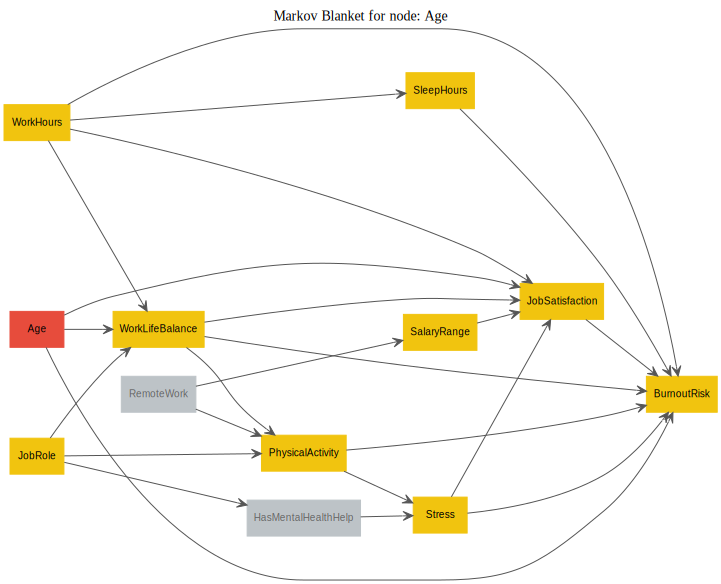


--- Visualizing the Markov Blanket of: BurnoutRisk ---


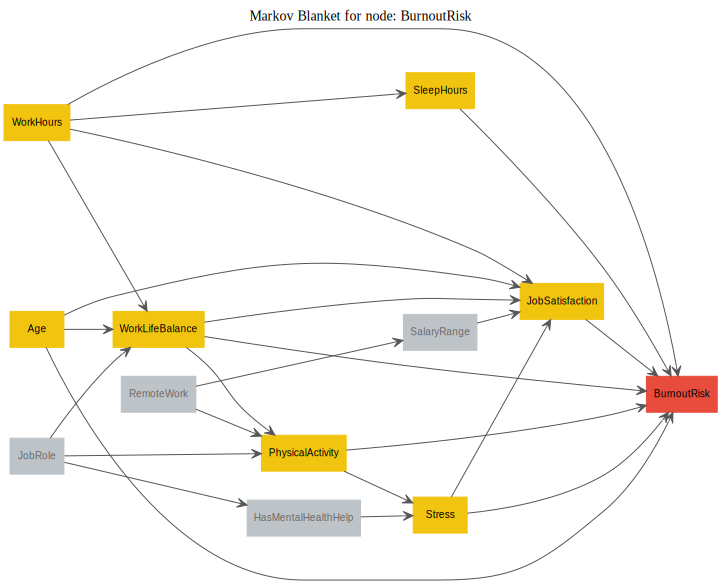


--- Visualizing the Markov Blanket of: HasMentalHealthHelp ---


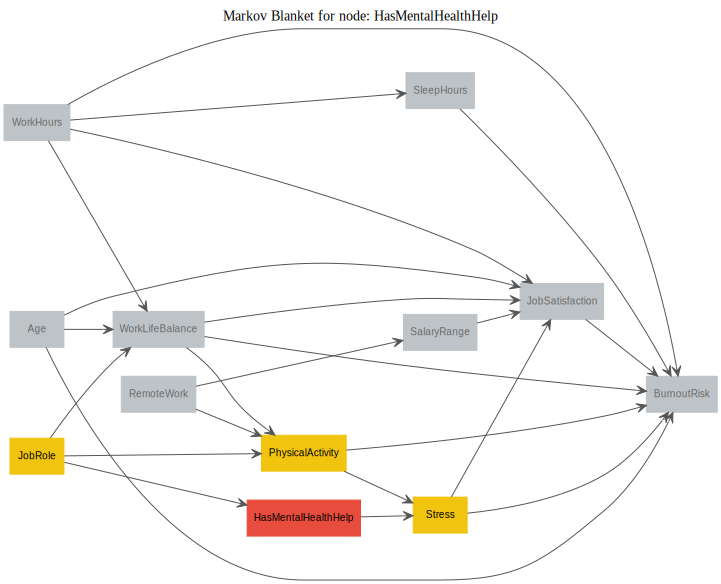


--- Visualizing the Markov Blanket of: JobRole ---


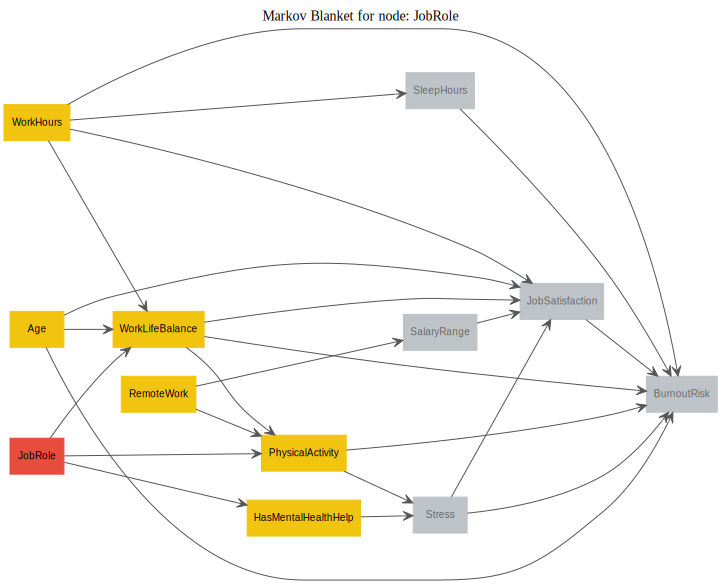


--- Visualizing the Markov Blanket of: JobSatisfaction ---


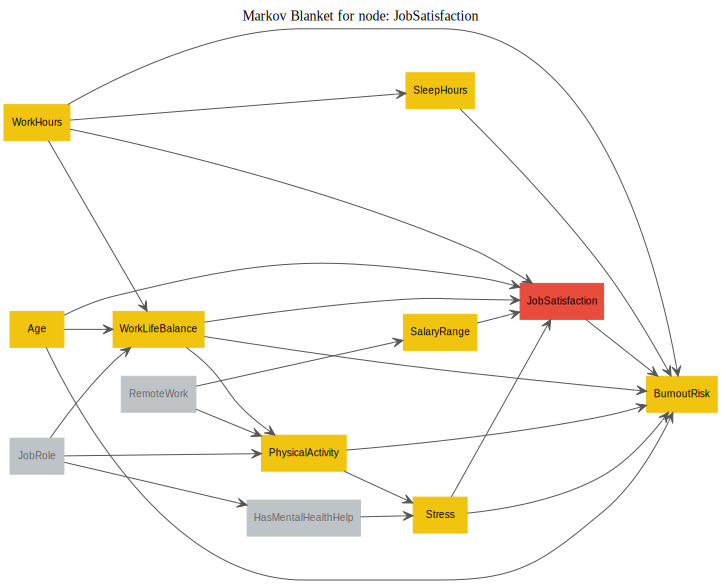


--- Visualizing the Markov Blanket of: PhysicalActivity ---


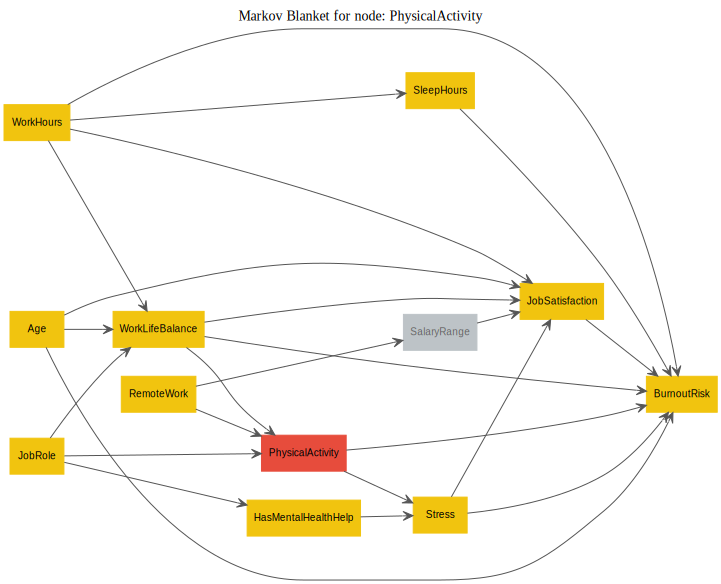


--- Visualizing the Markov Blanket of: RemoteWork ---


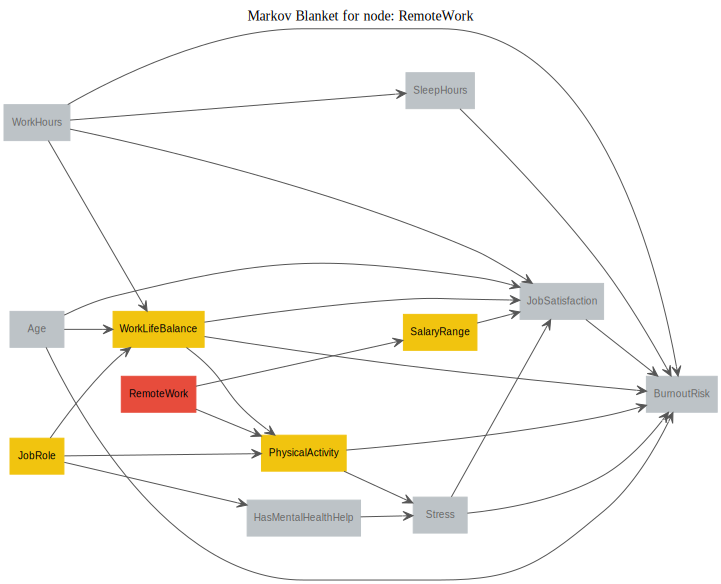


--- Visualizing the Markov Blanket of: SalaryRange ---


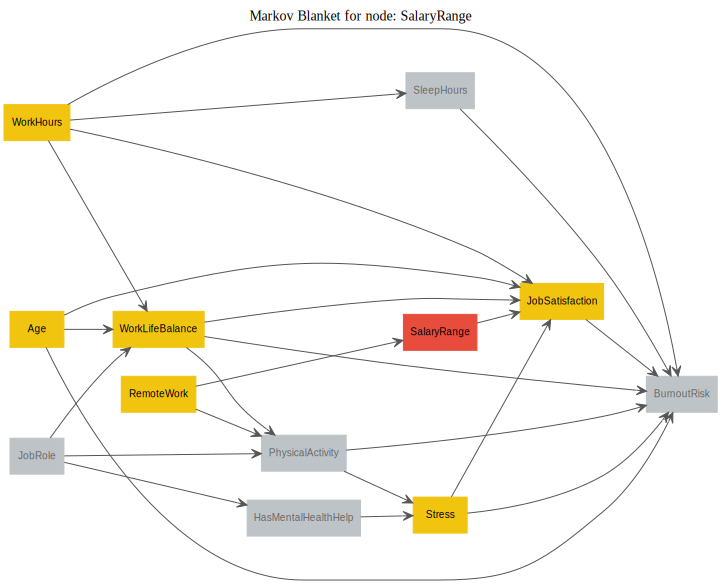


--- Visualizing the Markov Blanket of: SleepHours ---


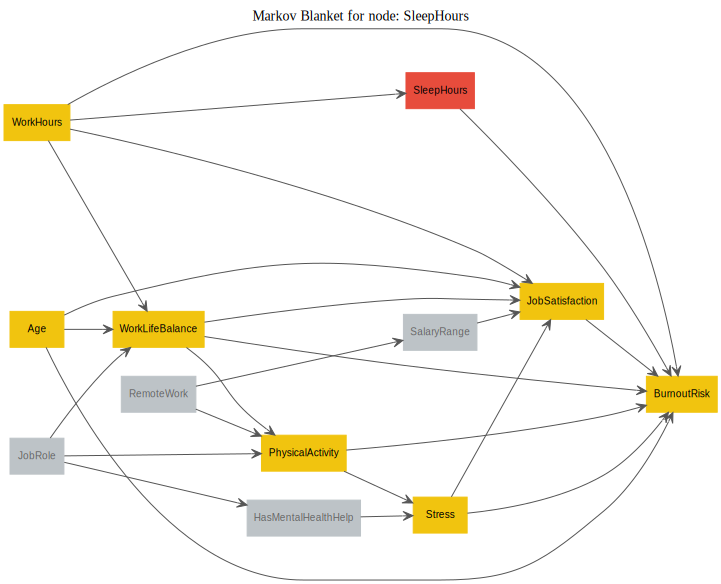


--- Visualizing the Markov Blanket of: Stress ---


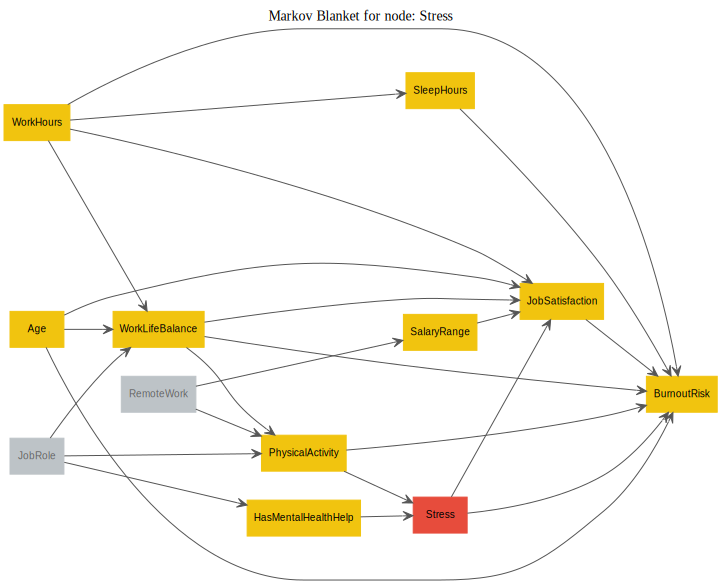


--- Visualizing the Markov Blanket of: WorkHours ---


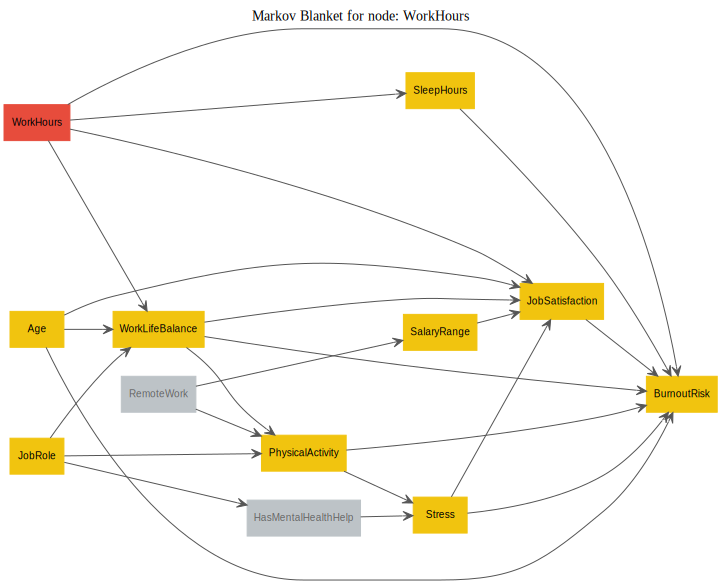


--- Visualizing the Markov Blanket of: WorkLifeBalance ---


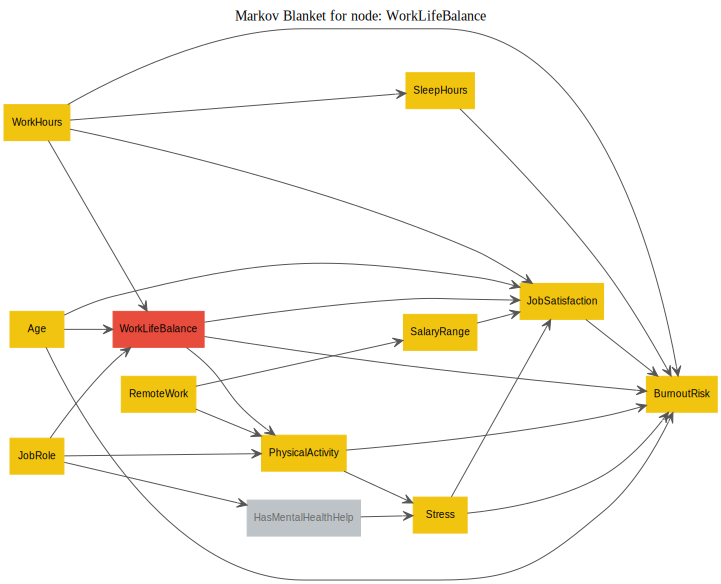



  Operation completed.


In [26]:
# ----------------------------------------------------------------------
# Visualization of Markov Blankets for each node
# ----------------------------------------------------------------------

print(f"Displaying {len(model.nodes())} graphs, one for each node.")
print("The graphs will be displayed below, in the cell output.")


# Loop through each individual node
for target_node in sorted(model.nodes()):

    print(f"\n--- Visualizing the Markov Blanket of: {target_node} ---")

    # Compute the blanket for the current node
    blanket_nodes = model.get_markov_blanket(node=target_node)

    # Create a new Digraph object for this specific graph
    dot = graphviz.Digraph(comment=f'Markov Blanket of {target_node}')
    dot.attr(rankdir='LR', splines='spline', overlap='false', nodesep='0.4', ranksep='0.6',
             label=f'Markov Blanket for node: {target_node}', labelloc='t', fontsize='14')
    dot.attr('node', shape='box', style='rounded,filled', fontname='Helvetica', fontsize='10')
    dot.attr('edge', color='#555555', arrowhead='vee', penwidth='1.0')


    target_color = '#e74c3c'  # Red for the target
    blanket_color = '#f1c40f' # Yellow for the blanket
    default_color = '#bdc3c7' # Grey for the rest

    # Color the nodes based on their role (target, blanket, other)
    for node in model.nodes():
        if node == target_node:
            dot.node(node, style='filled', color=target_color)
        elif node in blanket_nodes:
            dot.node(node, style='filled', color=blanket_color)
        else:
            dot.node(node, style='filled', color=default_color, fontcolor='#666666')

    # Draw all edges
    dot.edges(model.edges())

    display(dot)

print("\n\n  Operation completed.")